In [196]:
# Configurations
# Number of records to query from BigQuery
# None pulls all records   
limit=None
# Private key to access BiqQuery   
keyLocation = 'resource\local-receiver-341803-261a3b7beea6.json'
# Old Table = '`local-receiver-341803.testTrainEvents.train-event-data`'
tableLocation = '`local-receiver-341803.trainEvents04_26.train-event-data`'
# If true, will randomize the aggregate dataframe.
randomizeDataFrame = False

# Testing parameters
trainDataPercentage = 0.7
valDataPercentage = 0.2

In [197]:
import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

from google.cloud import bigquery

# Fetch Credentials - I created a key then literally dragged/dropped it to /content on google colab 
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = keyLocation

# Build BigQuery Client
client = bigquery.Client()

In [198]:
# Get the dataset
# Query for Position Histories from BigQuery - change limit after we know it works
limitClause = '' if limit==None else ' Limit ' + str(limit)
QUERY = ('SELECT lastTrainReporting FROM ' + tableLocation + limitClause) 
query_job = client.query(QUERY)

# Wait for job to finish
rows = query_job.result()

print("Num rows fetched: " + str(rows.total_rows))

Num rows fetched: 4777


In [199]:
# Define Utility Functions to build additional data rows

# Create a dataframe row holding a record of position on the train.
def createPositionHistoryFrame(positionHistory) -> dict:
    # The time that the train was at the specific milepost
    # Record the position time as seconds from epoch to use in regression model
    positionTime = positionHistory.get('positionTime')
    # How fast the train is traveling
    speedMPH = positionHistory.get('speedMPH')
    # Milepost location information
    milepostLocation = positionHistory.get('milepostLocation')
    # The unique identifier of the subdivision
    subdivisionId = milepostLocation.get('subdivisionId')
    trackName = milepostLocation.get('trackName')
    # The unique identifier fo the milepost
    milepostNumber = milepostLocation.get('milepost').get('milepostNumber')

    # Construct new dataframe record
    return {'PositionTime': positionTime, 'SpeedMPH': speedMPH, 
    'SubdivisionId': subdivisionId, 'TrackName':trackName, 'MilepostNumber':milepostNumber}

# Create a dataframe row for the identifier information of the trani
def createTrainIdFrame(trainId) -> dict:
    trainSymbol = trainId.get('trainSymbol')
    return {'TrainSymbol': trainSymbol}

# Create data frame for train detail
def createTrainDetailFrame(trainDetail) -> dict:
    # Excluding Maximum Train Speed for NAN issue
    # maximumTrainSpeed = trainDetail.get('maximumTrainSpeed')
    loadedCarCount = trainDetail.get('loadedCarCount')
    emptyCarCount = trainDetail.get('emptyCarCount')
    trainLength = trainDetail.get('trainLength')
    trailingTonnage = trainDetail.get('trailingTonnage')

    # Construct new dataframe record
    return {'LoadedCarCount': loadedCarCount, 'EmptyCarCount': emptyCarCount, 'TrainLength':trainLength, 'TrailingTonnage':trailingTonnage}

In [200]:
# Fetch each position time and milepost
aggregateDataFrame = pd.DataFrame()

# Build trainEstimatedPositionList as we construct the training set.
trainEstimatedPositionDataFrame = pd.DataFrame()

# For each returned record
for row in rows:
    lastTrainReporting = row.get('lastTrainReporting')

    trainIdFrame = createTrainIdFrame(lastTrainReporting.get('trainId'))
    trainDetailFrame = createTrainDetailFrame(lastTrainReporting)

    # Scan each position history
    for positionHistory in lastTrainReporting.get('positionHistoryList'):
        # The time that the train was at the specific milepost
        # Record the position time as seconds from epoch to use in regression model
        positionHistoryFrame = createPositionHistoryFrame(positionHistory)

        # Add additional records to position history frame
        positionHistoryFrame.update(trainIdFrame)
        positionHistoryFrame.update(trainDetailFrame)

        # Append the row to the data frame.
        aggregateDataFrame = aggregateDataFrame.append(positionHistoryFrame, ignore_index = True)

    # Build the physics model list at the same time
    for estimatedPositionHistory in lastTrainReporting.get('trainEstimatedPositionList'):
        # The time that the train was at the specific milepost
        # Record the position time as seconds from epoch to use in regression model
        estimatedPositionHistoryFrame = createPositionHistoryFrame(estimatedPositionHistory)

        # Add additional records to position history frame
        estimatedPositionHistoryFrame.update(trainIdFrame)
        estimatedPositionHistoryFrame.update(trainDetailFrame)

        # Append the row to the data frame.
        trainEstimatedPositionDataFrame = trainEstimatedPositionDataFrame.append(estimatedPositionHistoryFrame, ignore_index = True)

# Return an item and drop from frame
date_time = pd.to_datetime(aggregateDataFrame.pop('PositionTime'), format='%Y-%m-%d %H:%M:%S')

print("date time: \n" + str(date_time))
print("cols: " + str(aggregateDataFrame.columns))

estimated_date_time = pd.to_datetime(trainEstimatedPositionDataFrame.pop('PositionTime'), format='%Y-%m-%d %H:%M:%S')

print("estimated date time: \n" + str(estimated_date_time))
print("estimated cols: " + str(trainEstimatedPositionDataFrame.columns))

trainEstimatedPositionDataFrame.head()

date time: 
0       2022-04-24 03:48:41+00:00
1       2022-04-24 03:48:11+00:00
2       2022-04-24 03:46:28+00:00
3       2022-04-24 03:45:50+00:00
4       2022-04-24 03:45:28+00:00
                   ...           
23880   2022-04-23 14:31:07+00:00
23881   2022-04-23 14:29:01+00:00
23882   2022-04-23 14:28:28+00:00
23883   2022-04-23 14:26:27+00:00
23884   2022-04-23 14:26:00+00:00
Name: PositionTime, Length: 23885, dtype: datetime64[ns, UTC]
cols: Index(['EmptyCarCount', 'LoadedCarCount', 'MilepostNumber', 'SpeedMPH',
       'SubdivisionId', 'TrackName', 'TrailingTonnage', 'TrainLength',
       'TrainSymbol'],
      dtype='object')
estimated date time: 
0        2022-04-24 03:48:41+00:00
1        2022-04-24 03:50:41+00:00
2        2022-04-24 03:52:41+00:00
3        2022-04-24 03:54:41+00:00
4        2022-04-24 03:56:41+00:00
                    ...           
107904   2022-04-23 16:23:07+00:00
107905   2022-04-23 16:25:07+00:00
107906   2022-04-23 16:27:07+00:00
107907   2022-04-23 1

EmptyCarCount  LoadedCarCount  MilepostNumber  SpeedMPH  SubdivisionId  \
0          101.0            51.0        765.4157     -15.0          106.0   
1          101.0            51.0        764.6830     -29.0          106.0   
2          101.0            51.0        763.5184     -39.0          106.0   
3          101.0            51.0        762.0587     -47.0          106.0   
4          101.0            51.0        760.4071     -50.0          106.0   

  TrackName  TrailingTonnage  TrainLength TrainSymbol  
0      MAIN           8425.0      10246.0       MSALI  
1      MAIN           8425.0      10246.0       MSALI  
2      MAIN           8425.0      10246.0       MSALI  
3      MAIN           8425.0      10246.0       MSALI  
4      MAIN           8425.0      10246.0       MSALI

In [201]:
# Handle Encoding of the data
# Note - to rerun this query - you need to run the above.
# Import label encoder
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
train_symbol_encoder = preprocessing.LabelEncoder()
physics_train_symbol_encoder = preprocessing.LabelEncoder()
track_name_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'TrainSymbol'.
aggregateDataFrame['TrainSymbol'] = train_symbol_encoder.fit_transform(aggregateDataFrame['TrainSymbol'])
trainEstimatedPositionDataFrame['TrainSymbol'] = physics_train_symbol_encoder.fit_transform(trainEstimatedPositionDataFrame['TrainSymbol'])

# Do I need a new encoder
aggregateDataFrame['TrackName'] = track_name_encoder.fit_transform(aggregateDataFrame['TrackName'])

# Can decode values with label encoder inverse
# inverse = label_encoder.inverse_transform(aggregateDataFrame['TrainSymbol'])

# Display Encoded Values
aggregateDataFrame.head()

EmptyCarCount  LoadedCarCount  MilepostNumber  SpeedMPH  SubdivisionId  \
0          101.0            51.0        765.4157     -15.0          106.0   
1          101.0            51.0        765.5480     -16.0          106.0   
2          101.0            51.0        766.0484     -17.0          106.0   
3          101.0            51.0        766.2317     -17.0          106.0   
4          101.0            51.0        766.3353     -16.0          106.0   

   TrackName  TrailingTonnage  TrainLength  TrainSymbol  
0          2           8425.0      10246.0           27  
1          2           8425.0      10246.0           27  
2          2           8425.0      10246.0           27  
3         14           8425.0      10246.0           27  
4         14           8425.0      10246.0           27

EmptyCarCount        36
LoadedCarCount       40
MilepostNumber     4272
SpeedMPH            127
SubdivisionId         7
TrackName            19
TrailingTonnage      55
TrainLength          57
TrainSymbol          32
dtype: int64


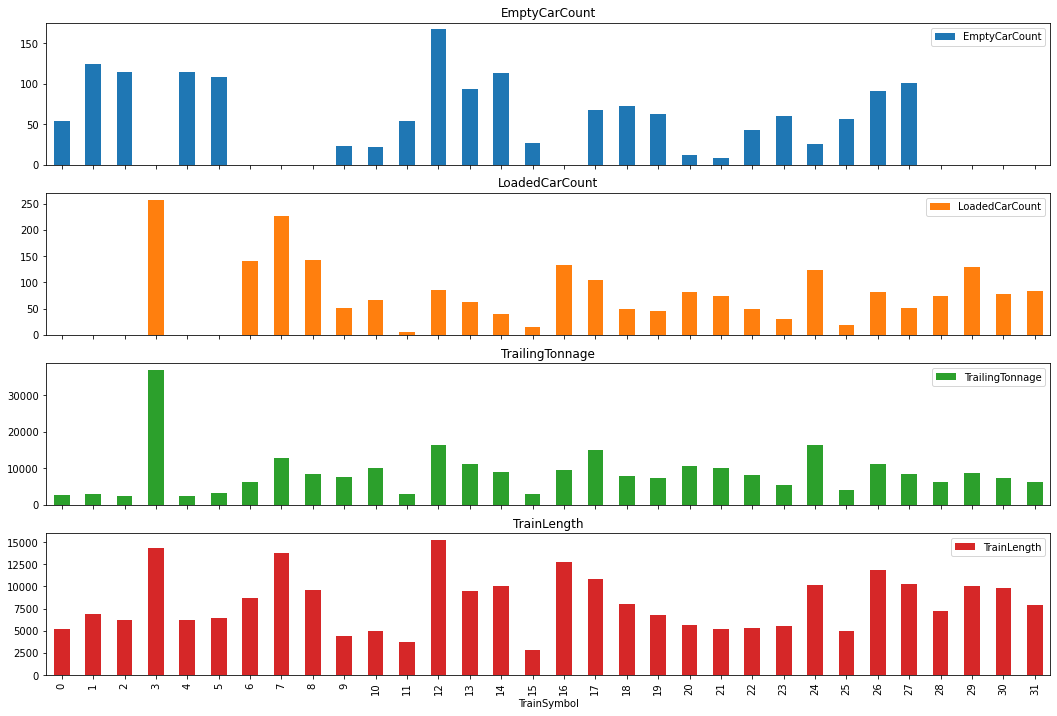

In [202]:
# Show of unique fields per column
print(aggregateDataFrame.nunique())

# Configuration Details of Train.
# Trailing Tonnage and Train Length may change if stops and picks are made.
config_plot_cols = ['TrainSymbol', 'EmptyCarCount', 'LoadedCarCount', 'TrailingTonnage', 'TrainLength']

# Plot configuration details by train
config_plot_features = aggregateDataFrame[config_plot_cols]
_ = config_plot_features[config_plot_cols].groupby('TrainSymbol').first().plot(subplots=True, sharex=True, kind='bar', figsize=(18,12))

C:\Users\mulli\AppData\Local\Programs\PythonCodingPack\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\mulli\AppData\Local\Programs\PythonCodingPack\lib\site-packages\pandas\plotting\_matplotlib\tools.py:185: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


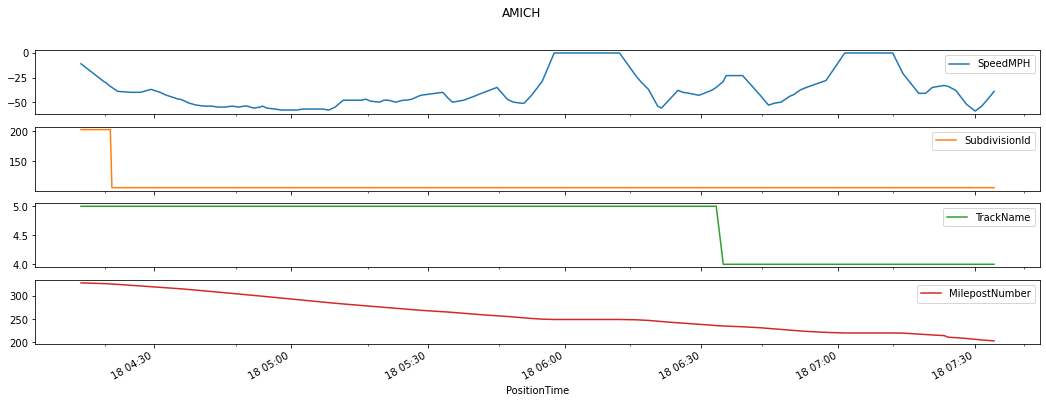

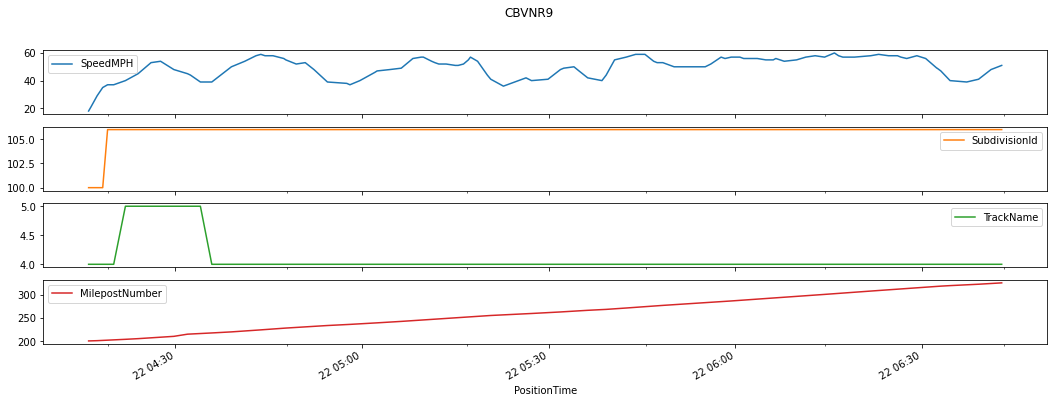

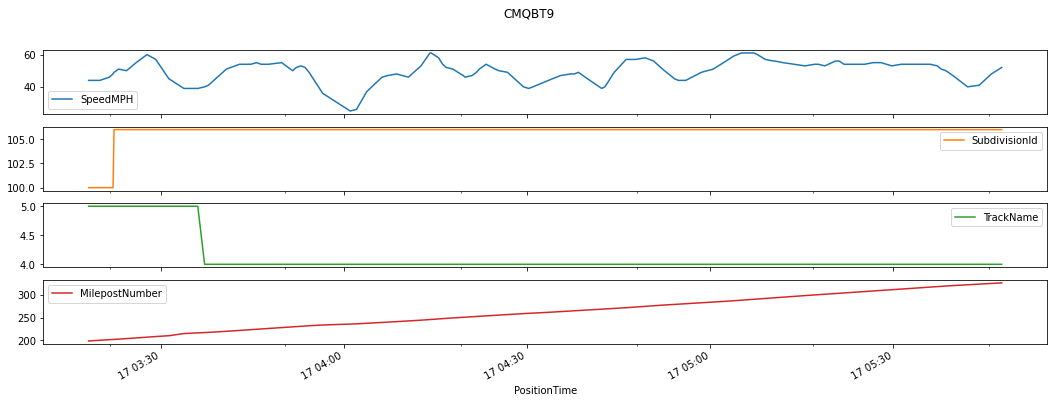

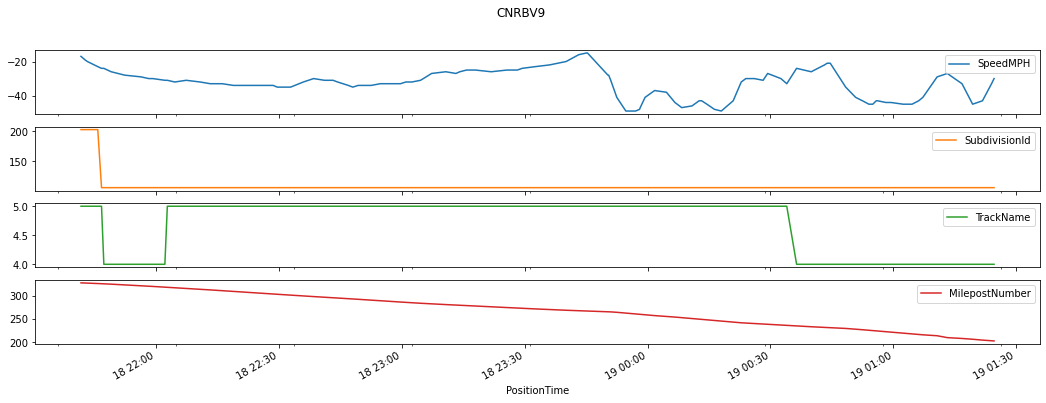

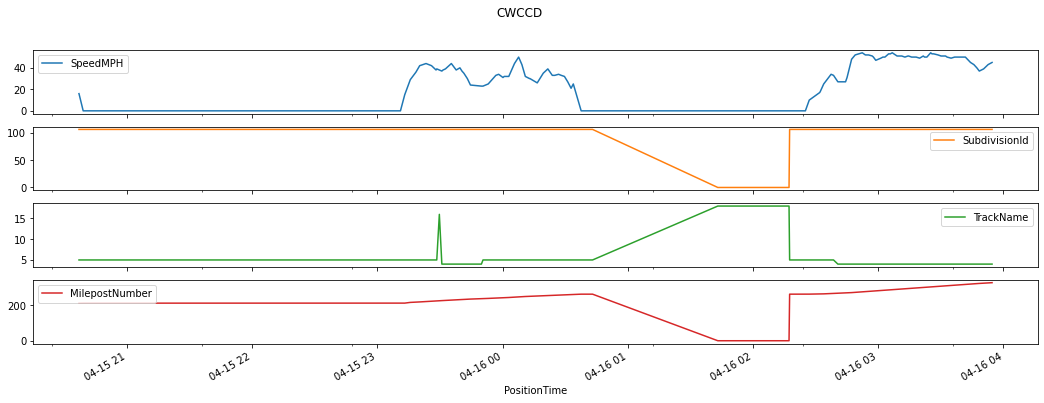

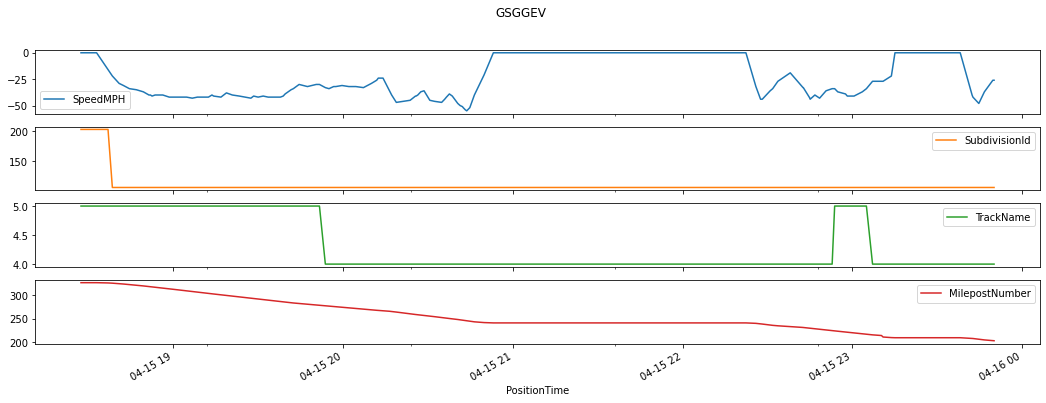

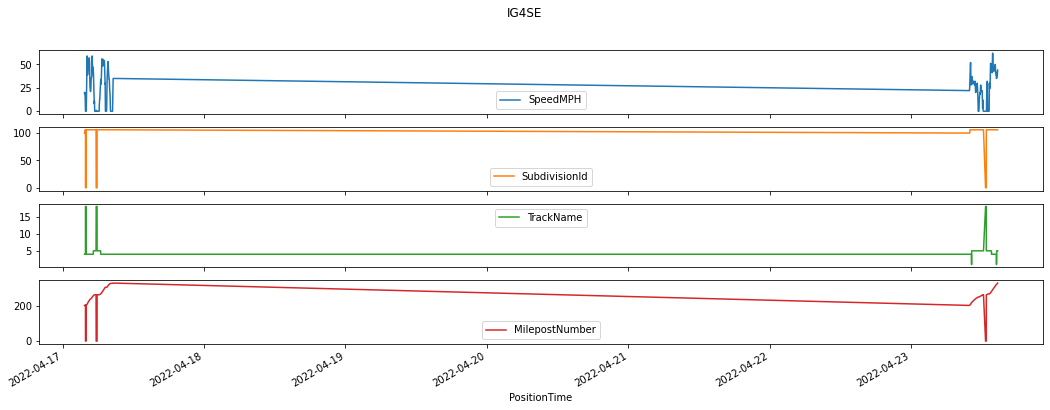

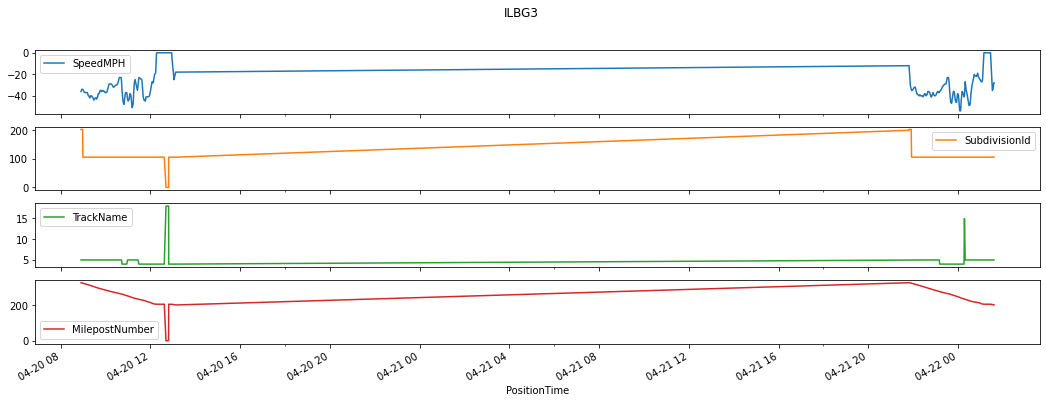

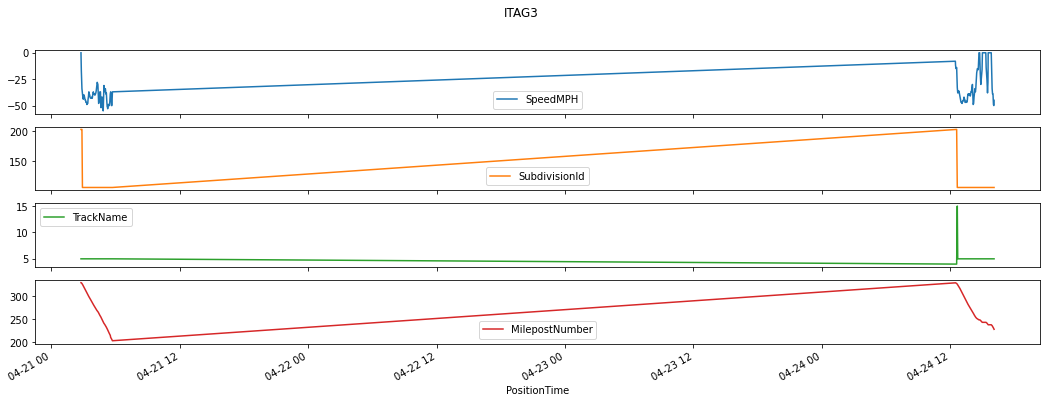

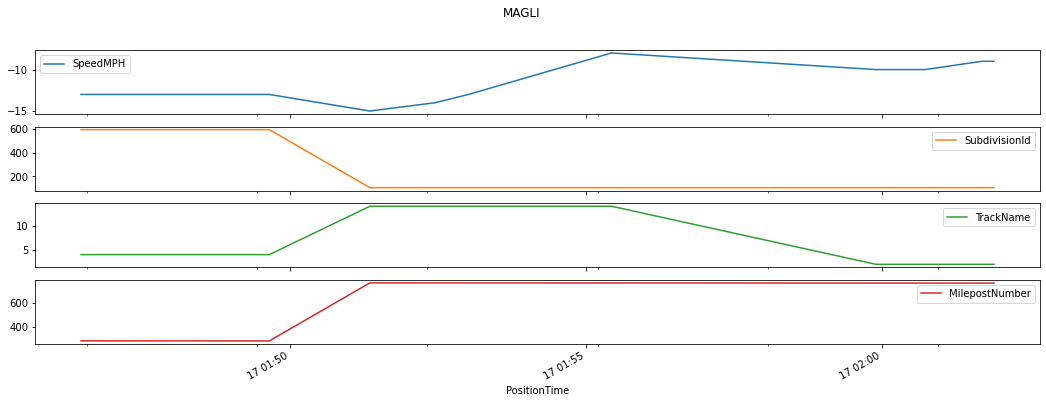

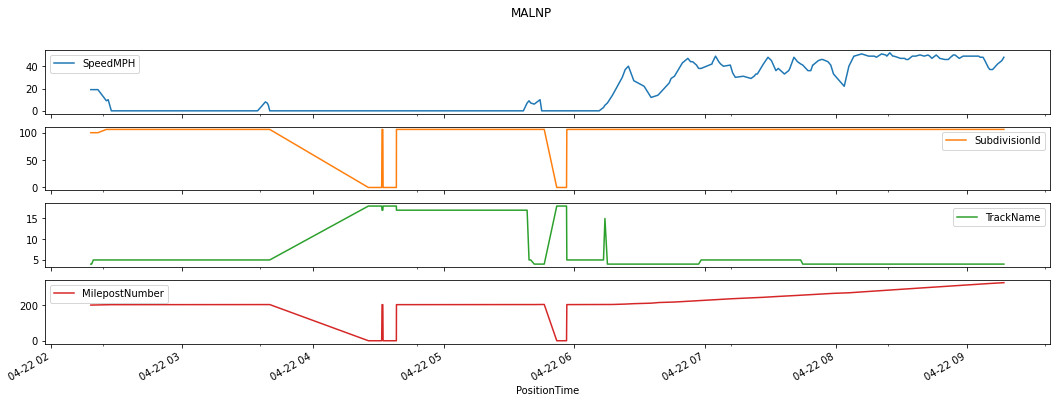

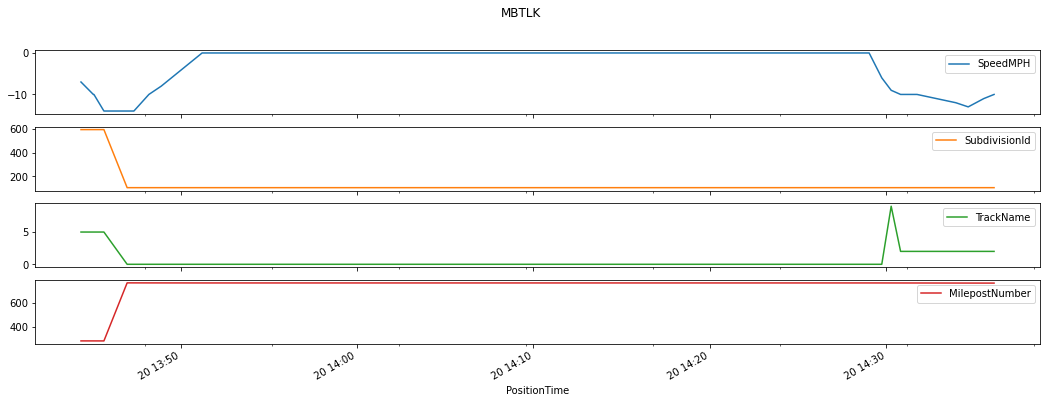

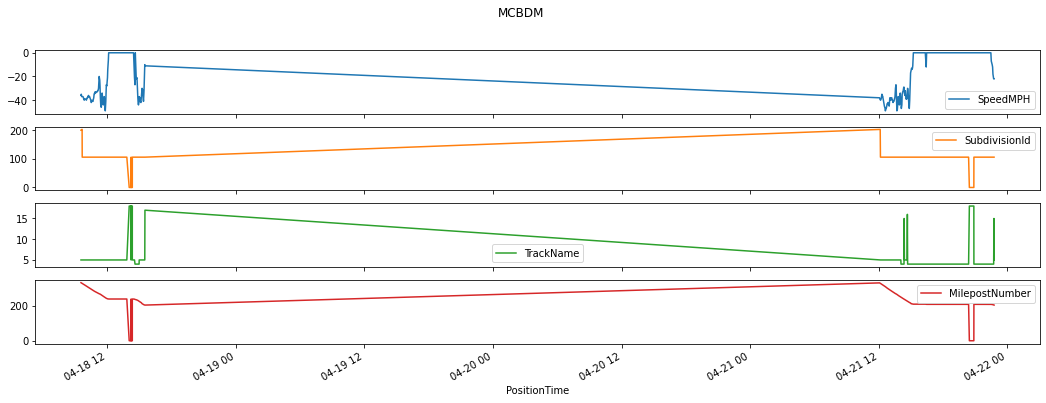

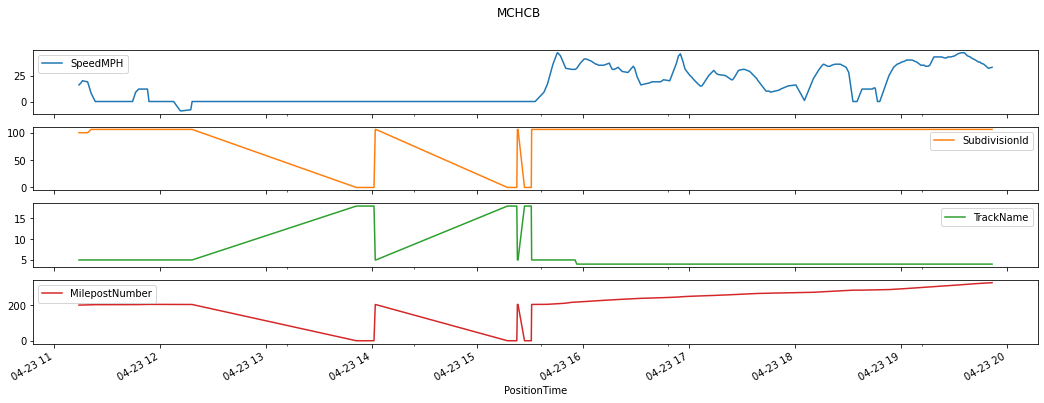

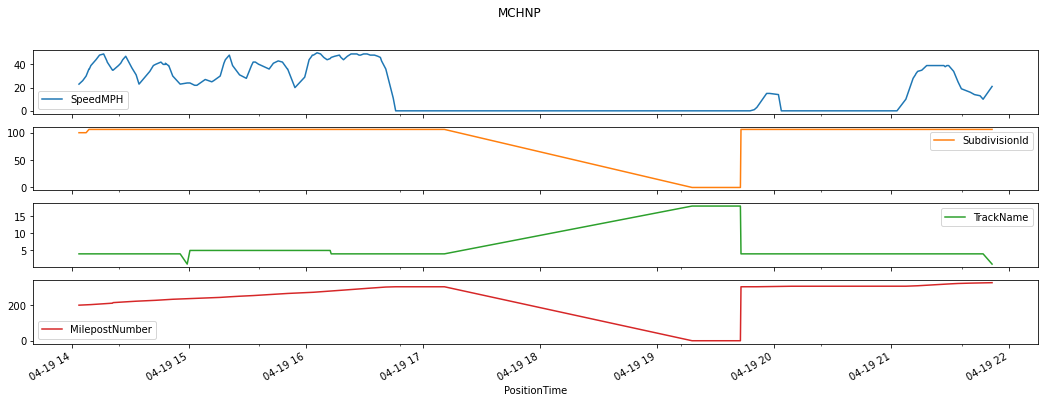

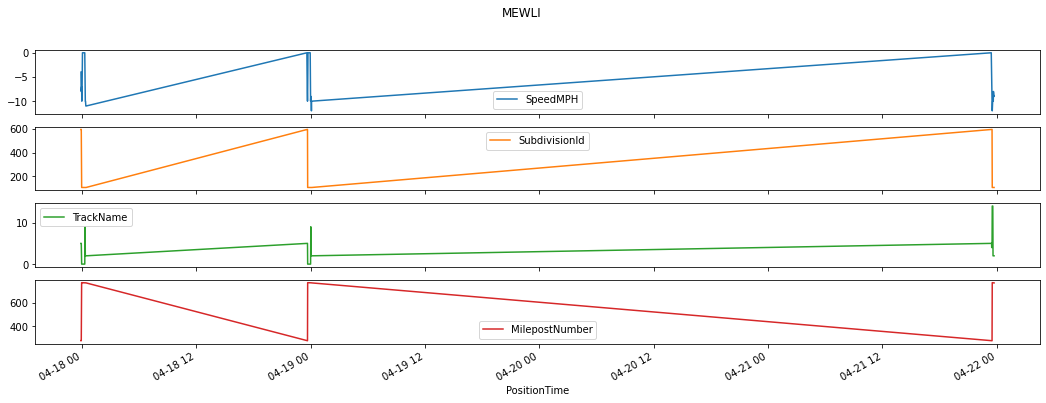

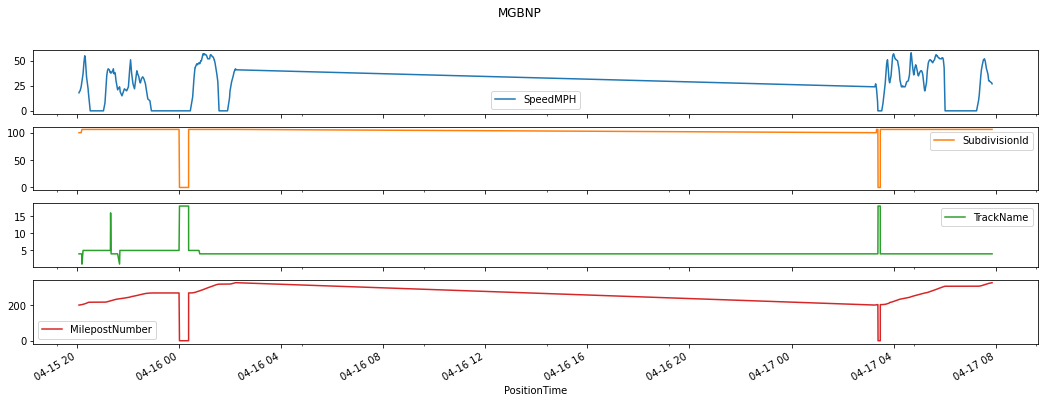

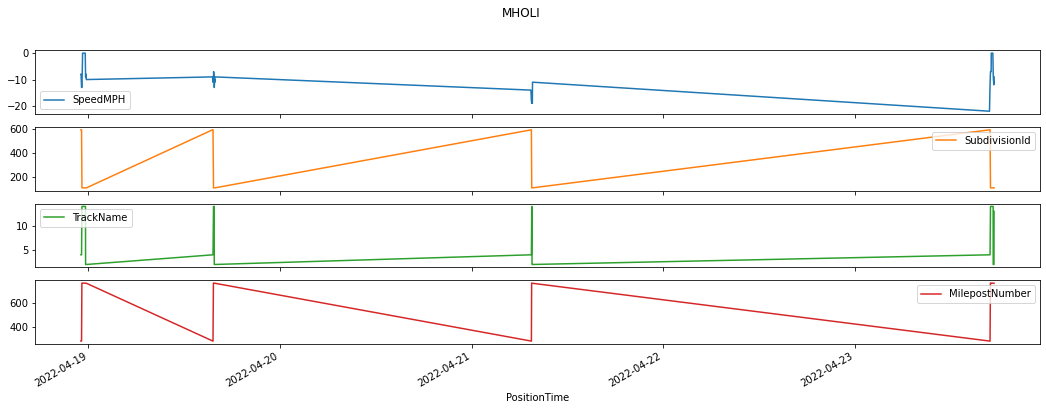

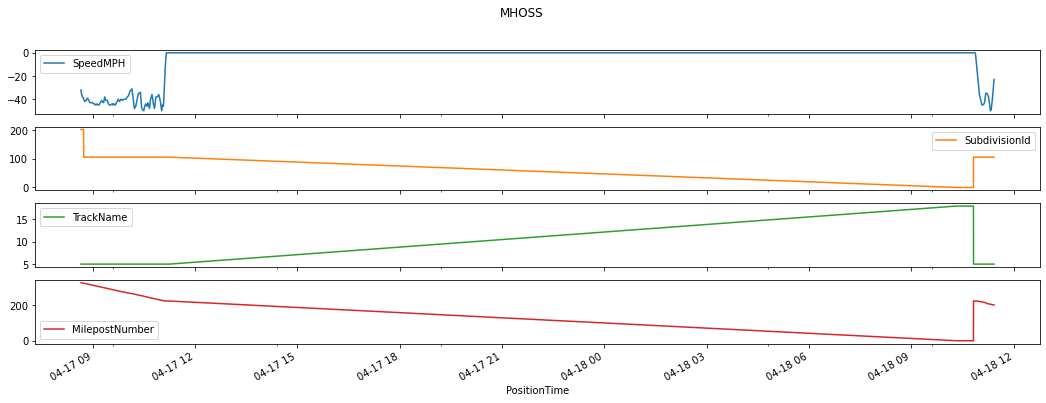

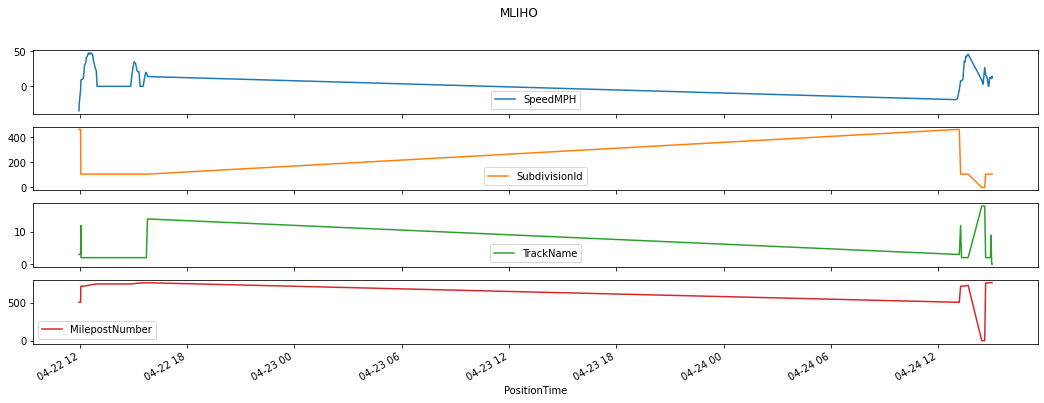

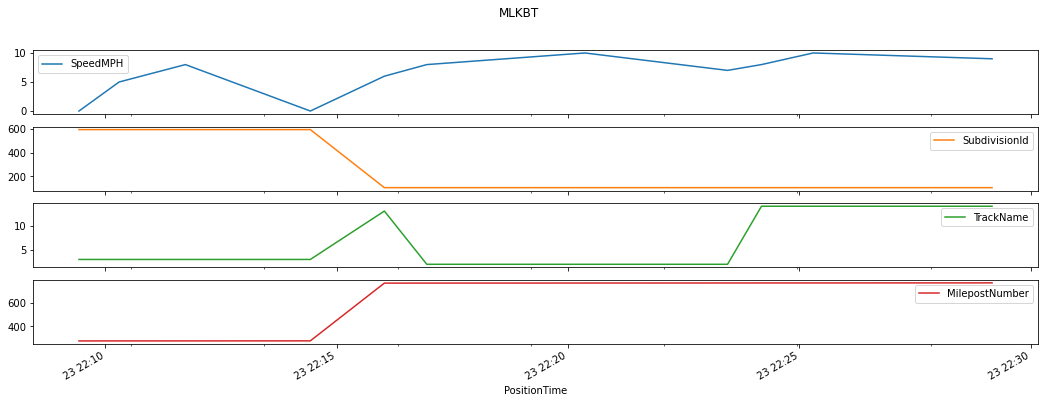

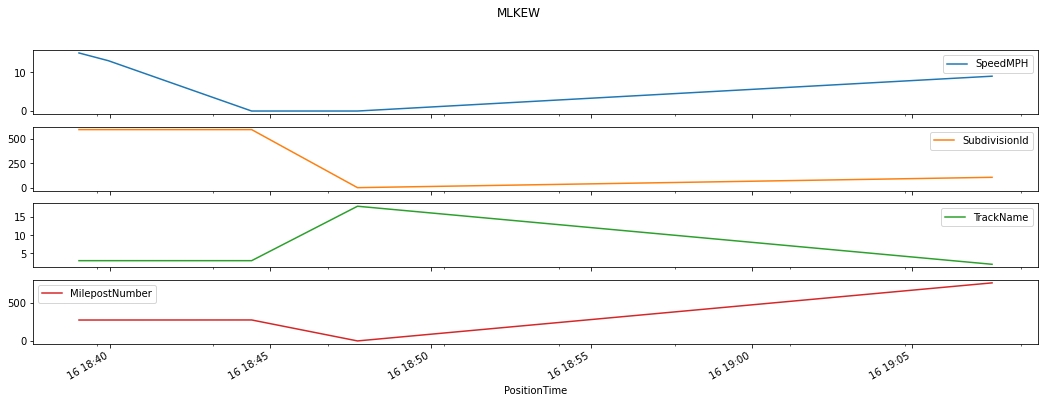

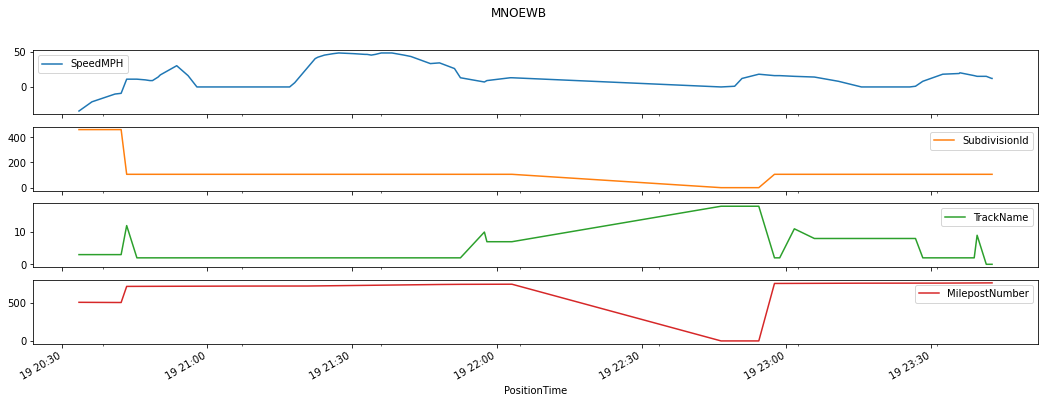

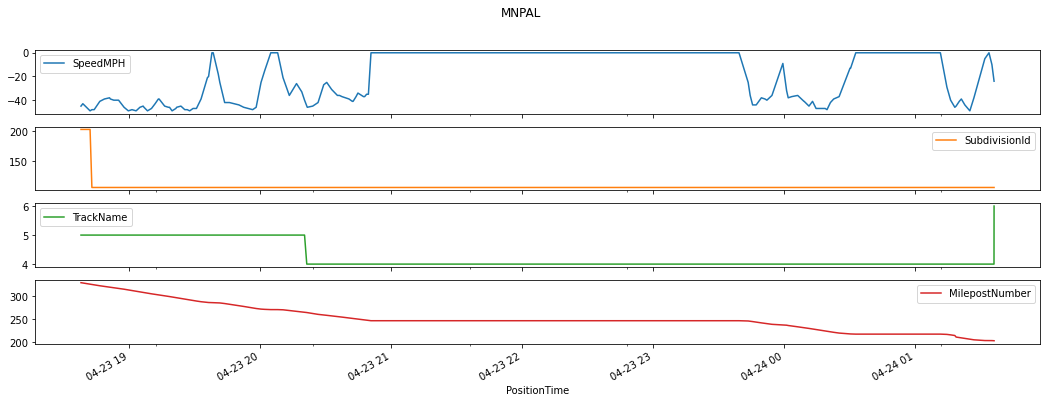

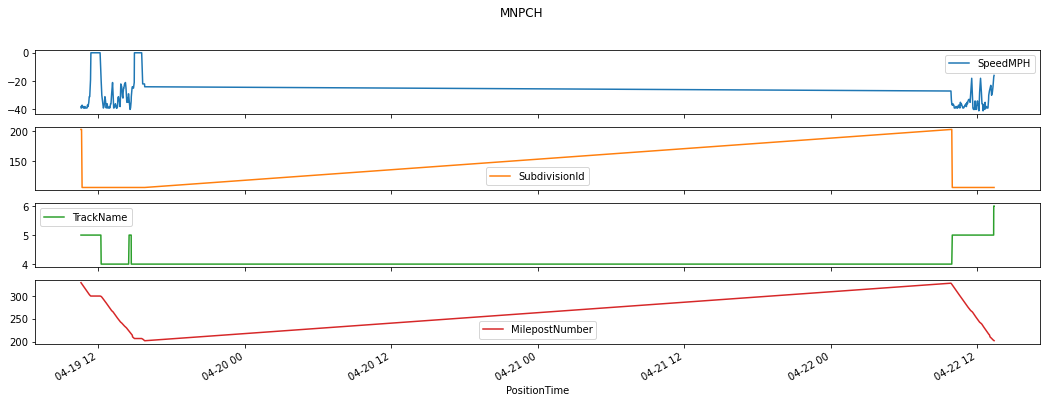

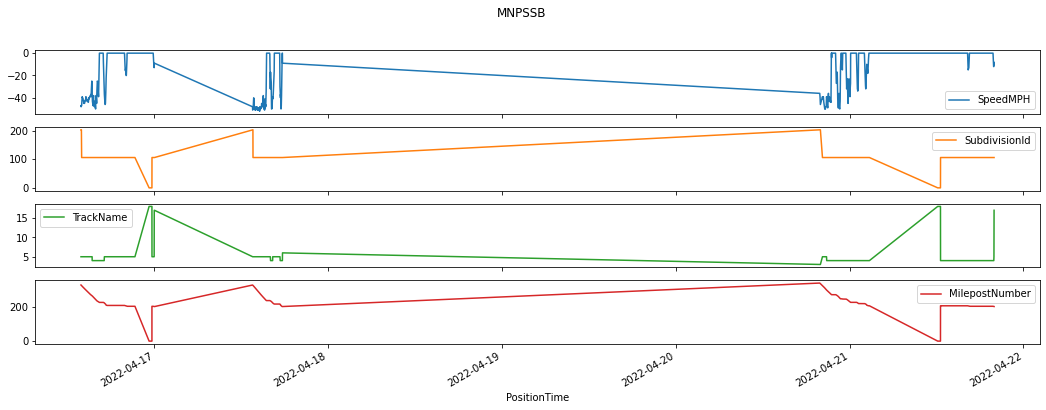

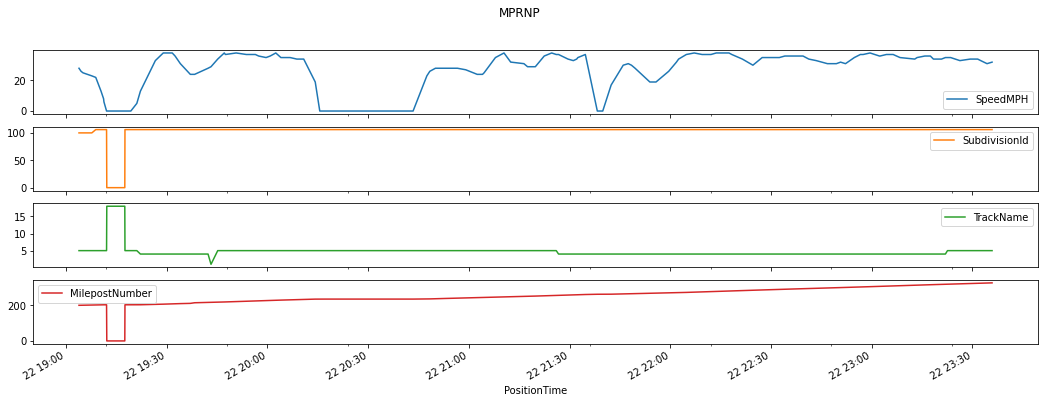

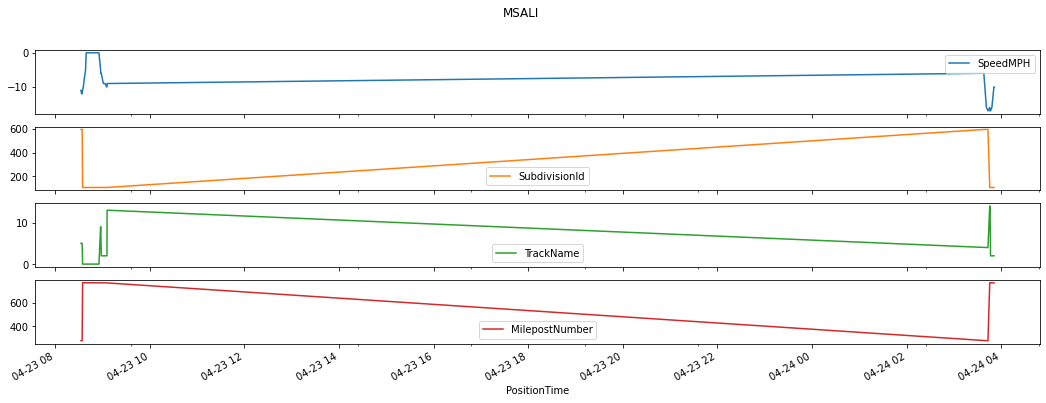

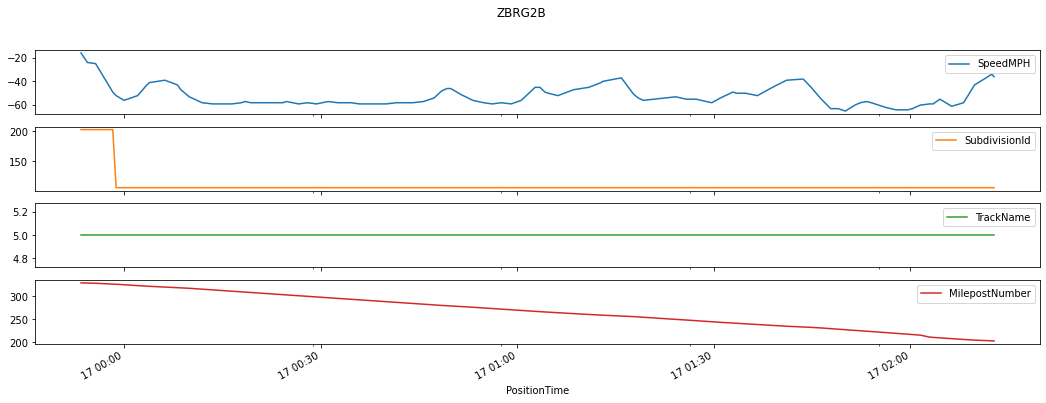

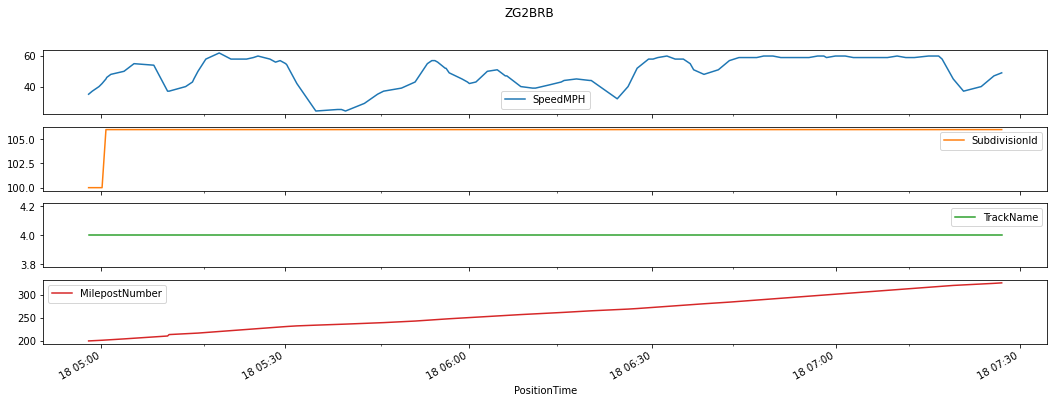

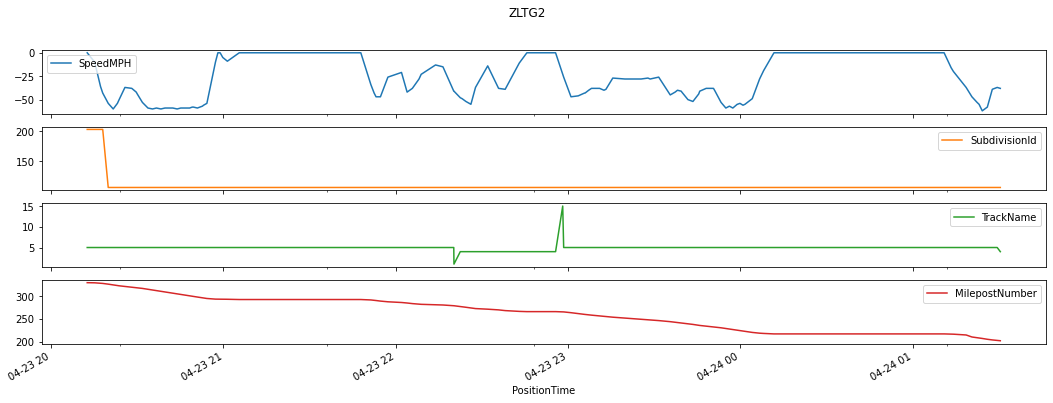

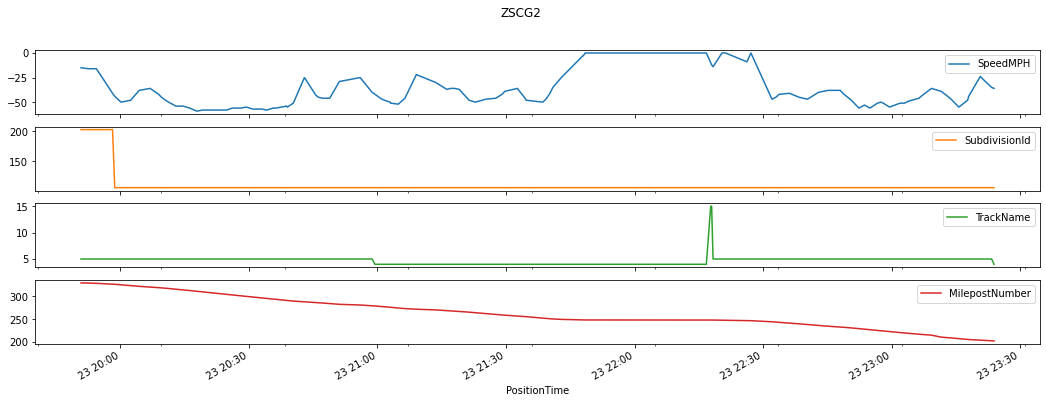

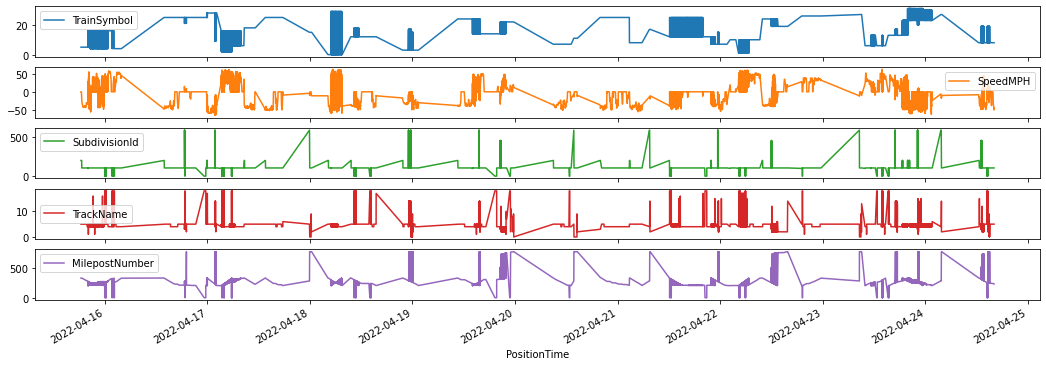

In [203]:
# Evolution of Features over time
plot_cols = ['TrainSymbol', 'SpeedMPH', 'SubdivisionId', 'TrackName', 'MilepostNumber']

# Plot data over time
# Data by train symbol
plot_features = aggregateDataFrame[plot_cols]
plot_features.index = date_time

# Inverse TrainSymbol
plot_features.loc[:,'TrainSymbol'] = train_symbol_encoder.inverse_transform(plot_features.loc[:,'TrainSymbol'])

groupby_df = plot_features[plot_cols].groupby('TrainSymbol')

# Iterate through subplots to add train symbol title
for key in groupby_df.groups.keys():
    groupby_df.get_group(key).plot(subplots=True, title=key, sharey=False, figsize=(18,6))

# Aggregate Data
plot_features = aggregateDataFrame[plot_cols][:limit]
plot_features.index = date_time[:limit]
_ = plot_features.plot(subplots=True, sharex=True, figsize=(18,6))

C:\Users\mulli\AppData\Local\Programs\PythonCodingPack\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


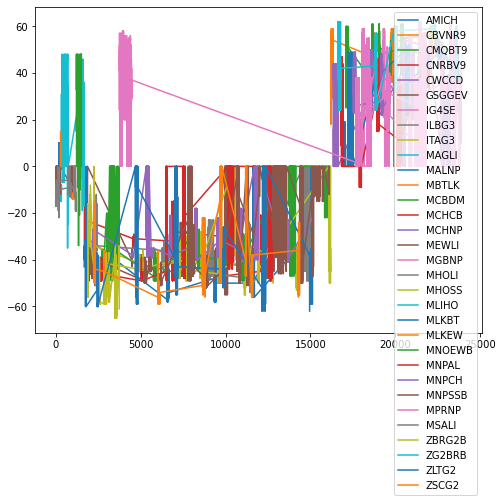

In [274]:
# Stacked
# Evolution of Features over time
stacked_plot_cols = ['TrainSymbol', 'SpeedMPH']
stacked_plot_features = aggregateDataFrame[stacked_plot_cols]

# Inverse TrainSymbol
stacked_plot_features.loc[:,'TrainSymbol'] = train_symbol_encoder.inverse_transform(stacked_plot_features.loc[:,'TrainSymbol'])

# Iterate through subplots to add train symbol title
fig, ax = plt.subplots()

for key, grp in stacked_plot_features[stacked_plot_cols].groupby('TrainSymbol'):
    ax = grp.plot(ax=ax, kind='line', y='SpeedMPH', label=key, )


   EmptyCarCount  LoadedCarCount  MilepostNumber  SpeedMPH  SubdivisionId  \
0          101.0            51.0        765.4157     -15.0          106.0   
1          101.0            51.0        764.6830     -29.0          106.0   
2          101.0            51.0        763.5184     -39.0          106.0   
3          101.0            51.0        762.0587     -47.0          106.0   
4          101.0            51.0        760.4071     -50.0          106.0   

  TrackName  TrailingTonnage  TrainLength  TrainSymbol  
0      MAIN           8425.0      10246.0           15  
1      MAIN           8425.0      10246.0           15  
2      MAIN           8425.0      10246.0           15  
3      MAIN           8425.0      10246.0           15  
4      MAIN           8425.0      10246.0           15  


C:\Users\mulli\AppData\Local\Programs\PythonCodingPack\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


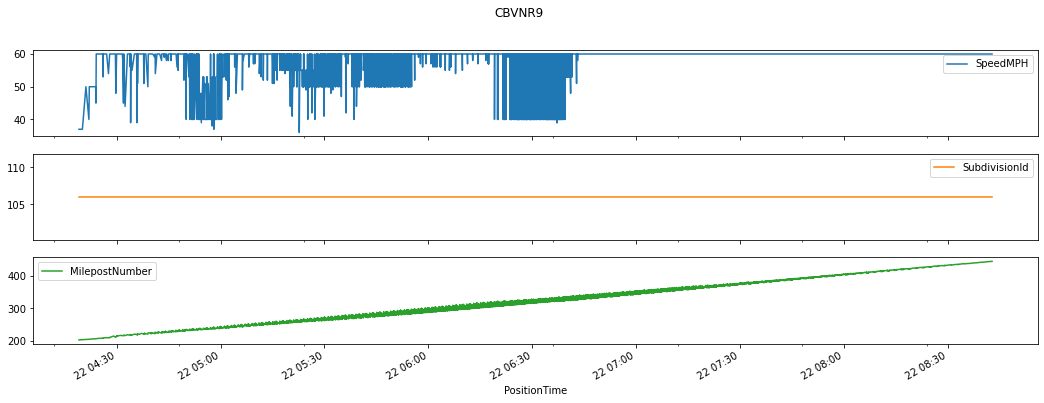

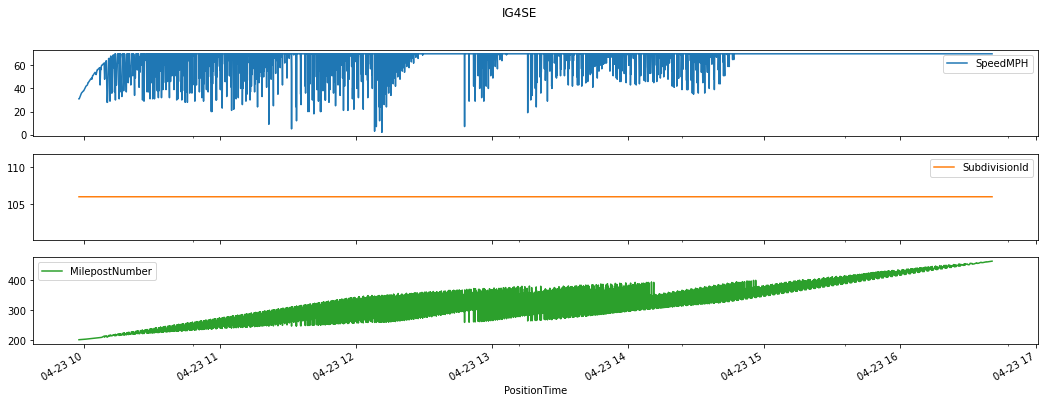

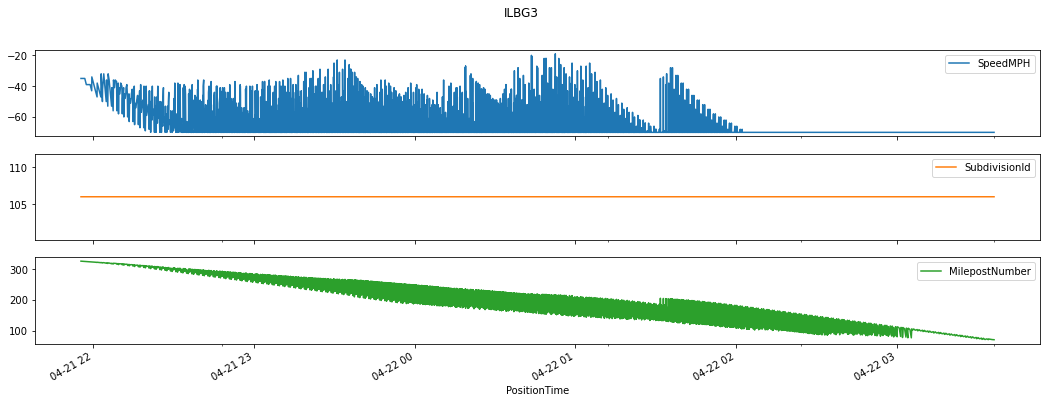

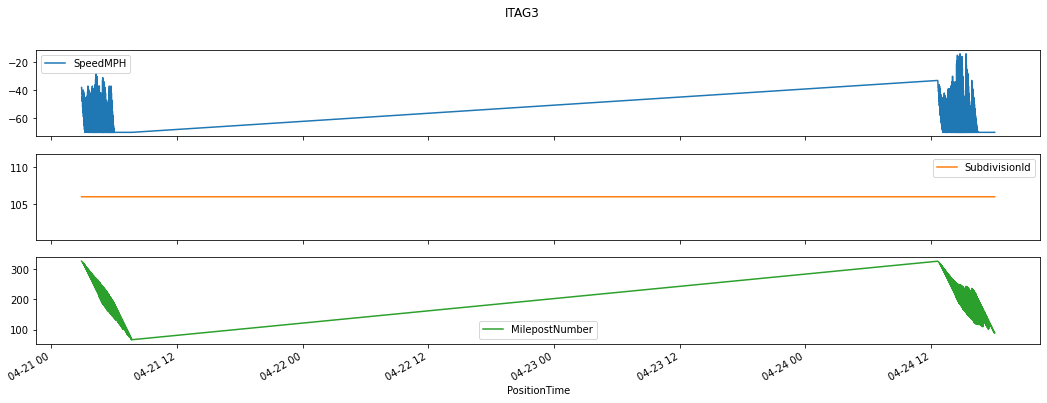

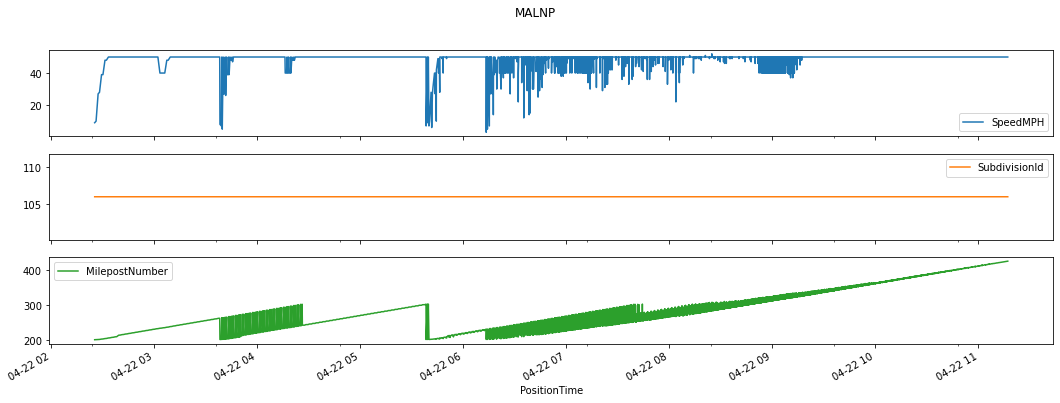

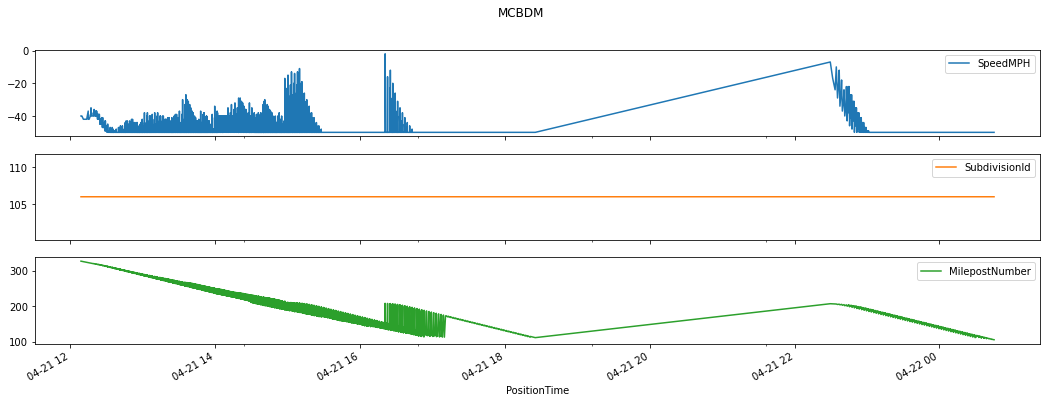

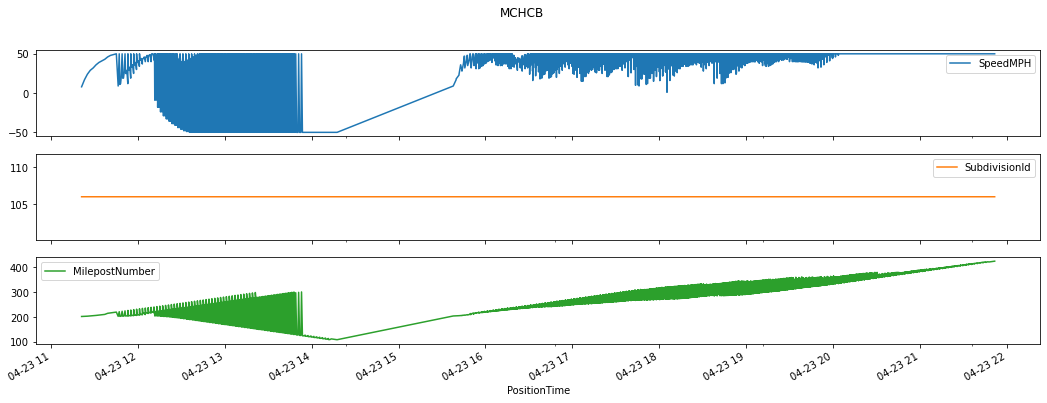

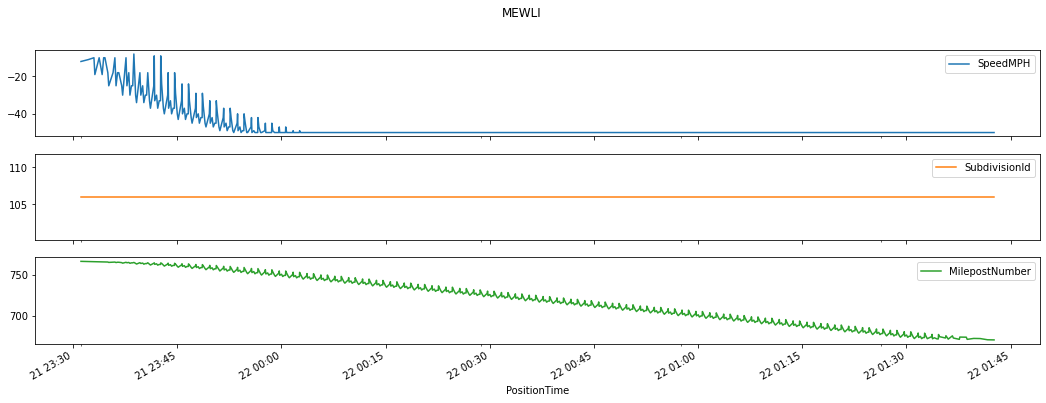

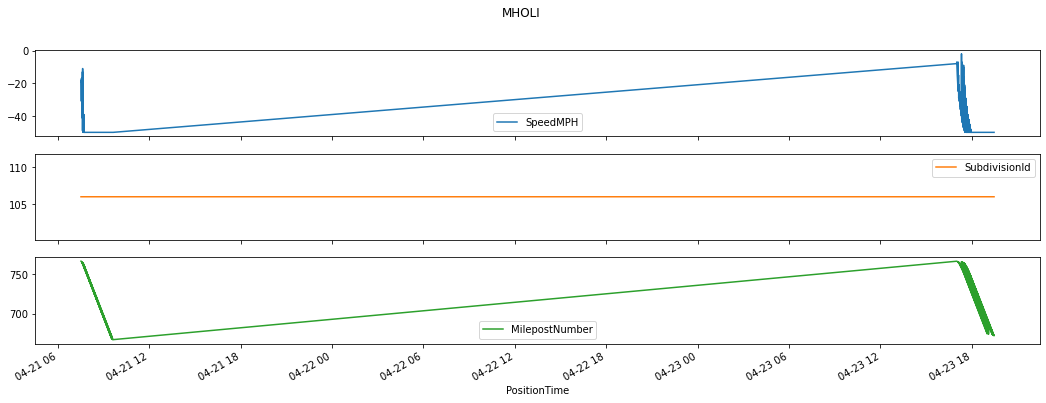

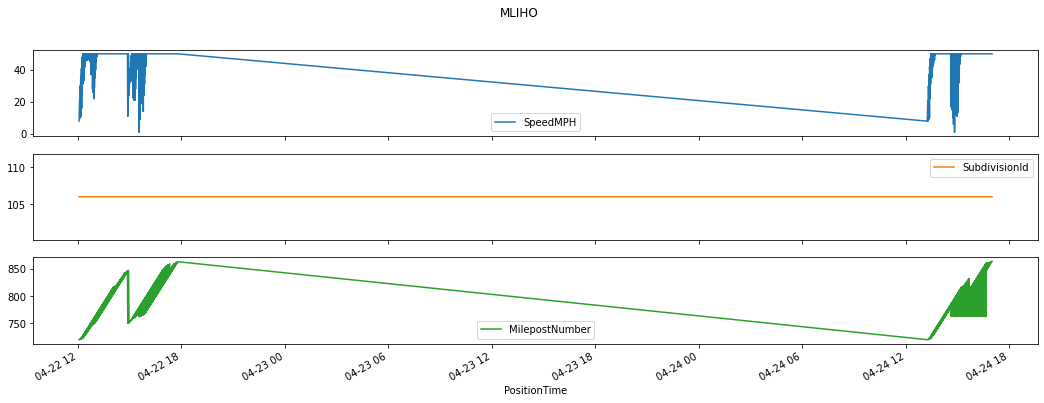

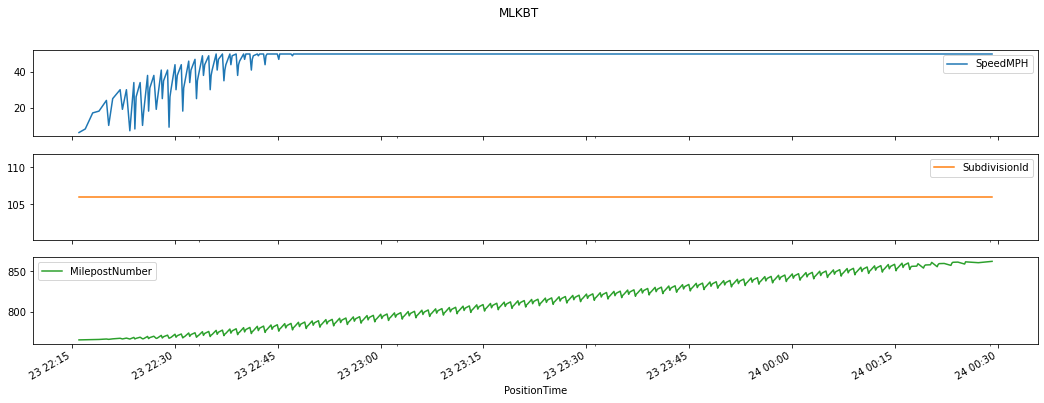

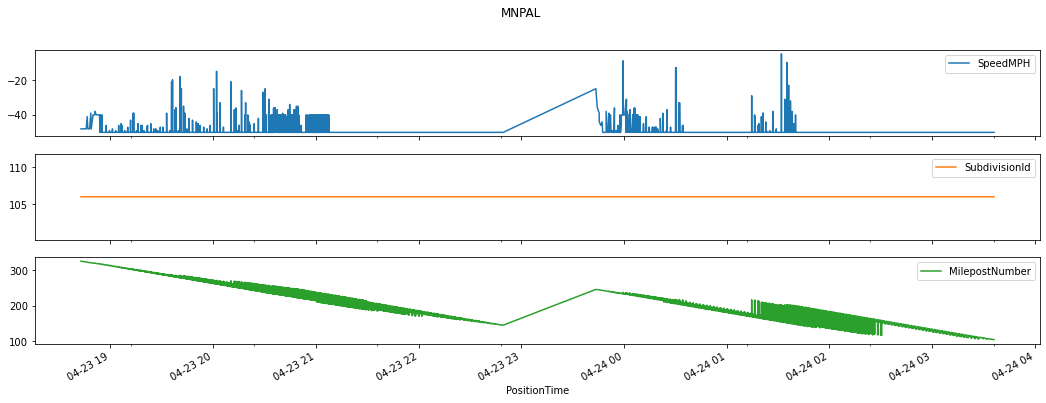

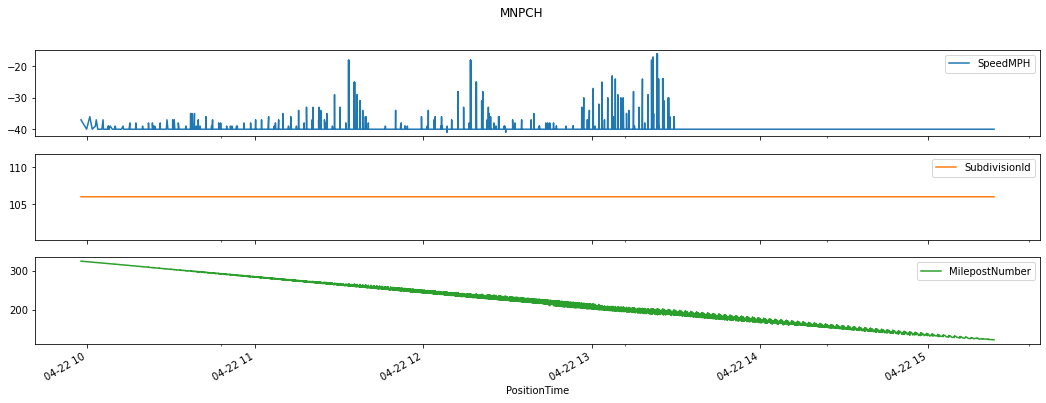

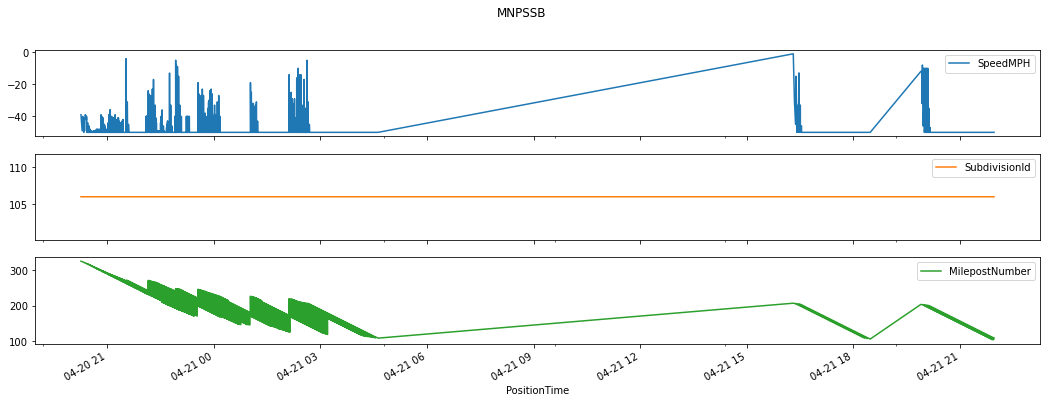

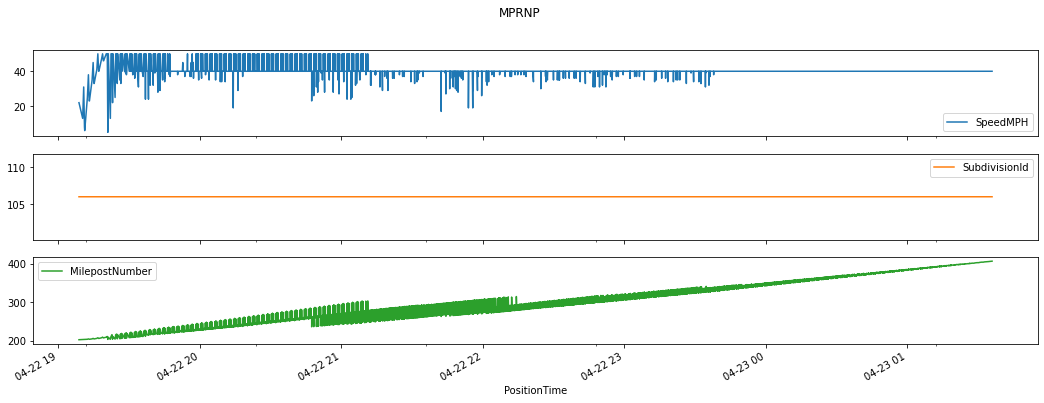

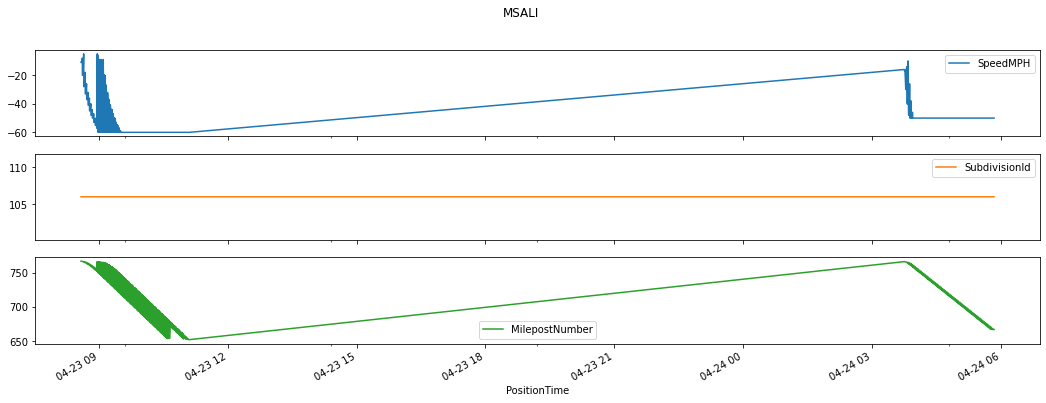

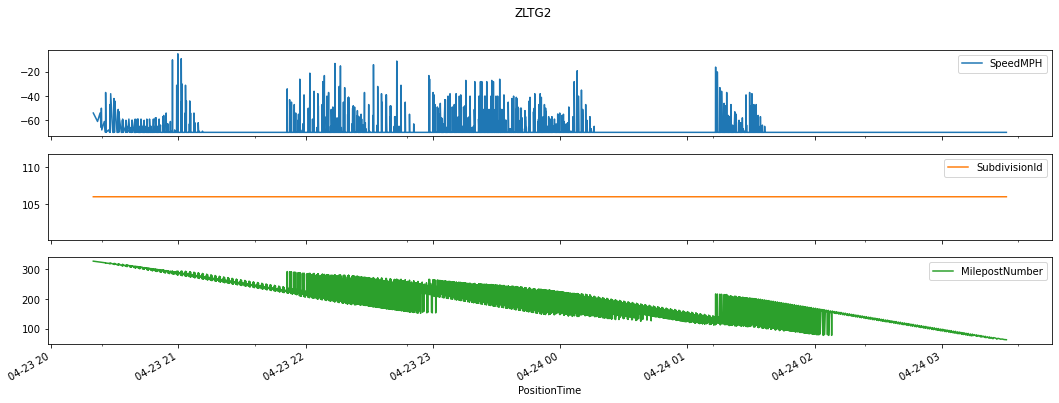

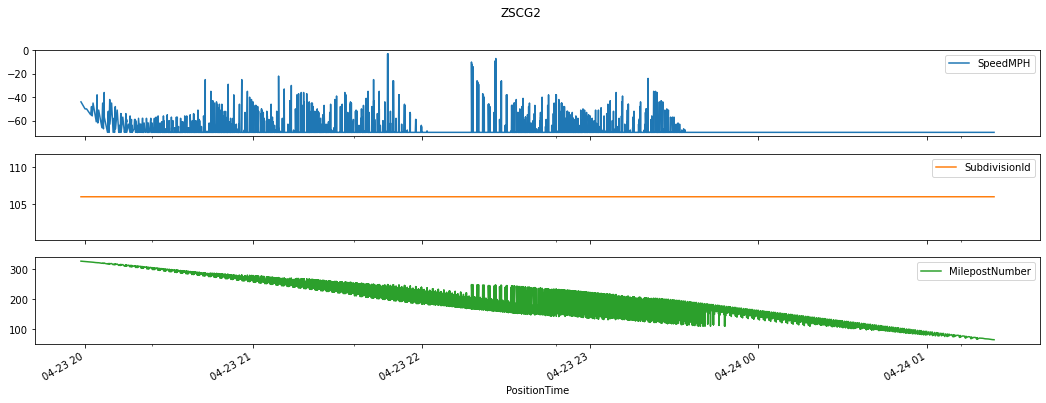

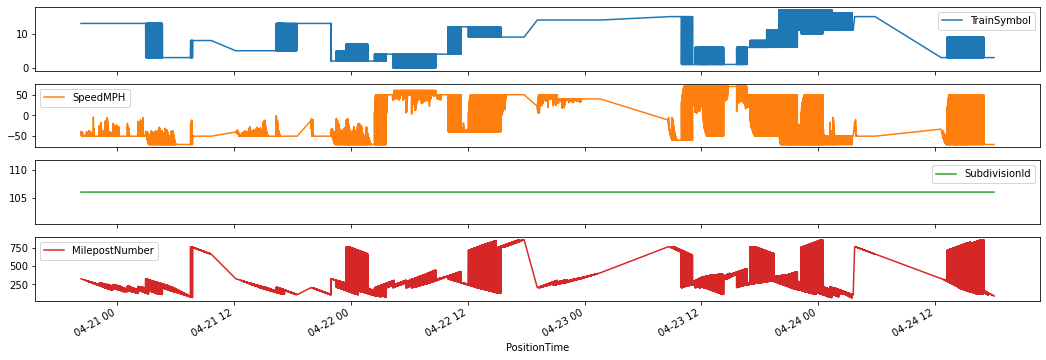

In [205]:
# Repeat for Physics Model Estimated Position. 
print(trainEstimatedPositionDataFrame.head())

# Data by train symbol
physics_plot_features = trainEstimatedPositionDataFrame[plot_cols]
physics_plot_features.index = estimated_date_time

# Inverse TrainSymbol
physics_plot_features.loc[:,'TrainSymbol'] = physics_train_symbol_encoder.inverse_transform(physics_plot_features.loc[:,'TrainSymbol'])
physics_groupby_df = physics_plot_features[plot_cols].groupby('TrainSymbol')

# Iterate through subplots to add train symbol title
for key in physics_groupby_df.groups.keys():
    physics_groupby_df.get_group(key).plot(subplots=True, title=key, sharey=False, figsize=(18,6))

# Aggregate Data
physics_plot_features = trainEstimatedPositionDataFrame[plot_cols][:limit]
physics_plot_features.index = estimated_date_time[:limit]
_ = physics_plot_features.plot(subplots=True, sharex=True, figsize=(18,6))

C:\Users\mulli\AppData\Local\Programs\PythonCodingPack\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


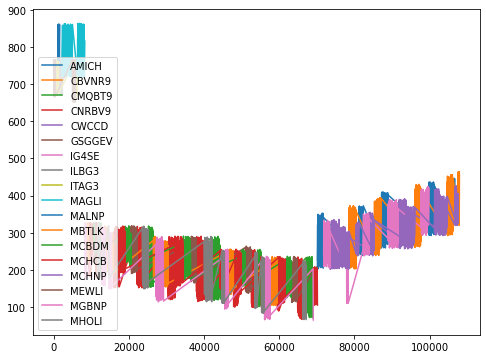

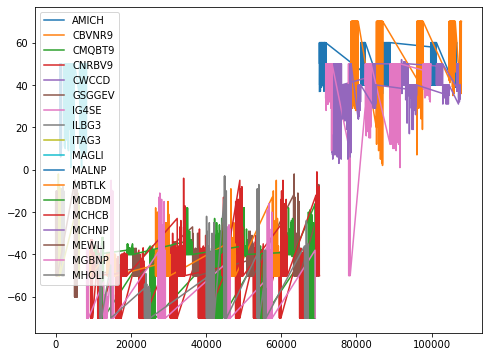

In [206]:
# Stacked
# Evolution of Features over time
stacked_phyics_plot_cols = ['TrainSymbol', 'SpeedMPH', 'MilepostNumber']
stacked_physics_plot_features = trainEstimatedPositionDataFrame[stacked_phyics_plot_cols]

# Inverse TrainSymbol
stacked_physics_plot_features.loc[:,'TrainSymbol'] = train_symbol_encoder.inverse_transform(stacked_physics_plot_features.loc[:,'TrainSymbol'])

# Iterate through subplots to add train symbol title
fig, ax = plt.subplots()
for key, grp in stacked_physics_plot_features[stacked_phyics_plot_cols].groupby('TrainSymbol'):
    ax = grp.plot(ax=ax, kind='line', y='MilepostNumber', label=key)

fig, ax = plt.subplots()
for key, grp in stacked_physics_plot_features[stacked_phyics_plot_cols].groupby('TrainSymbol'):
    ax = grp.plot(ax=ax, kind='line', y='SpeedMPH', label=key)

C:\Users\mulli\AppData\Local\Programs\PythonCodingPack\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


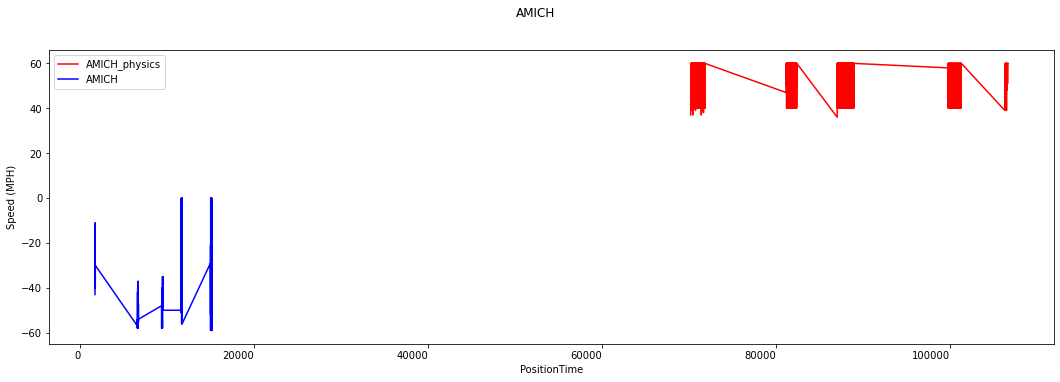

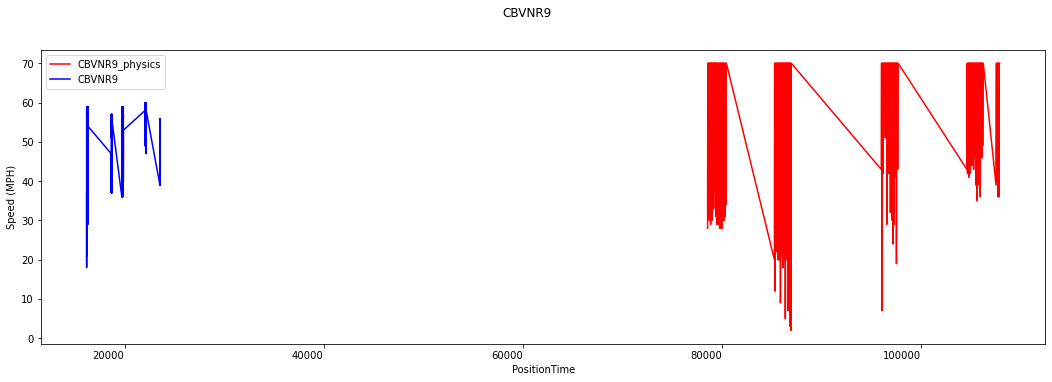

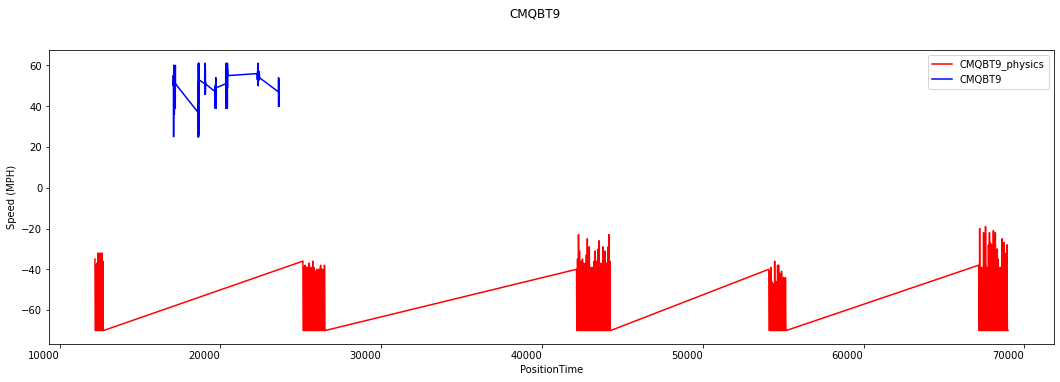

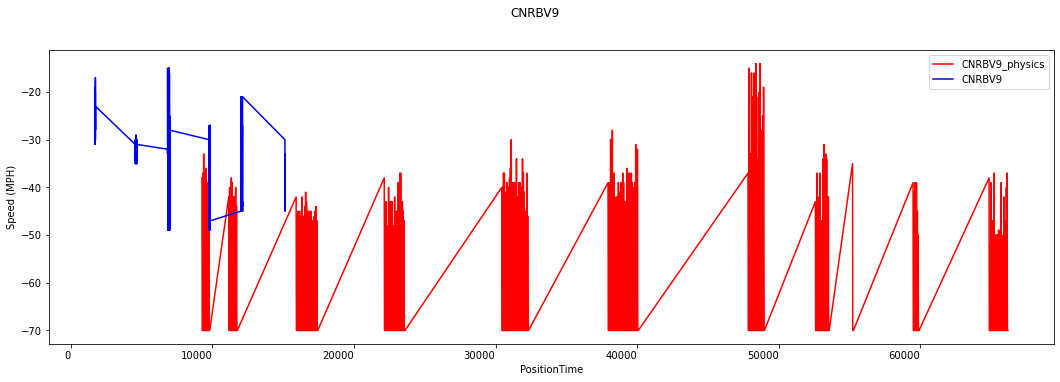

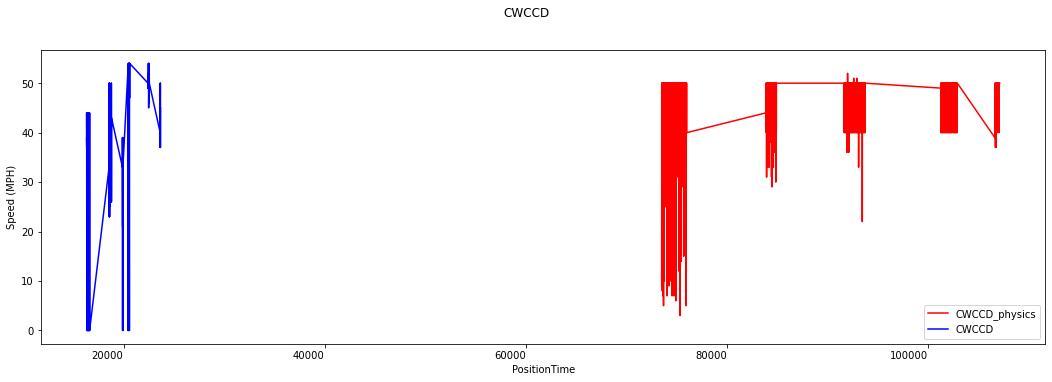

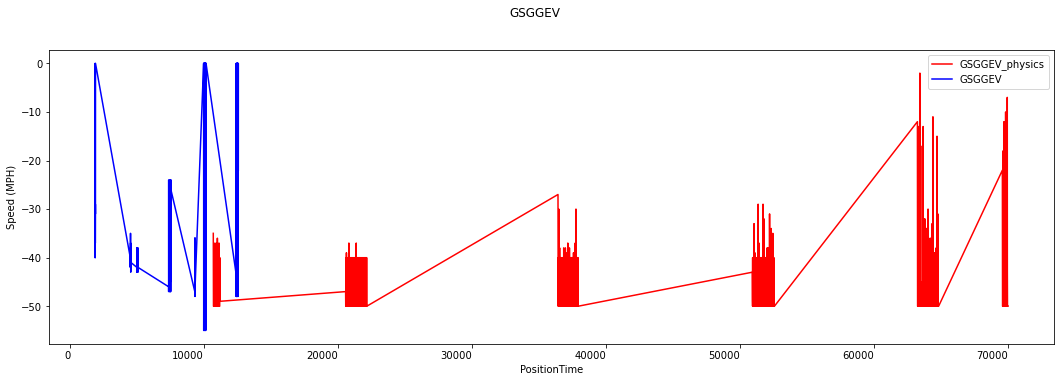

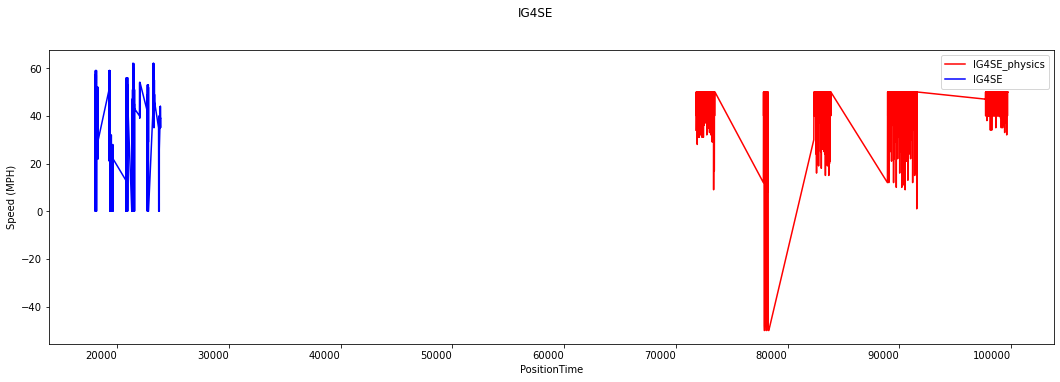

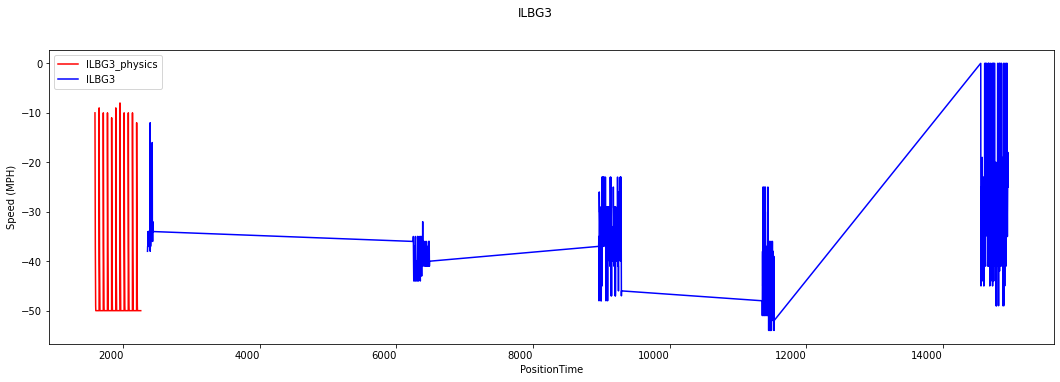

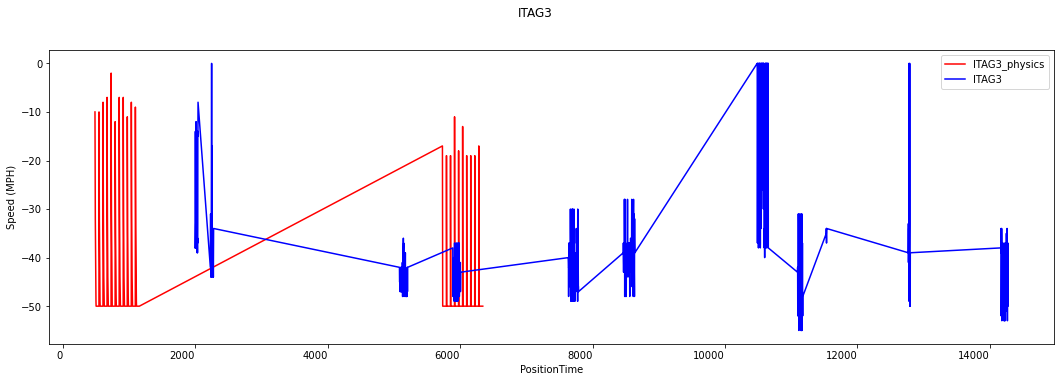

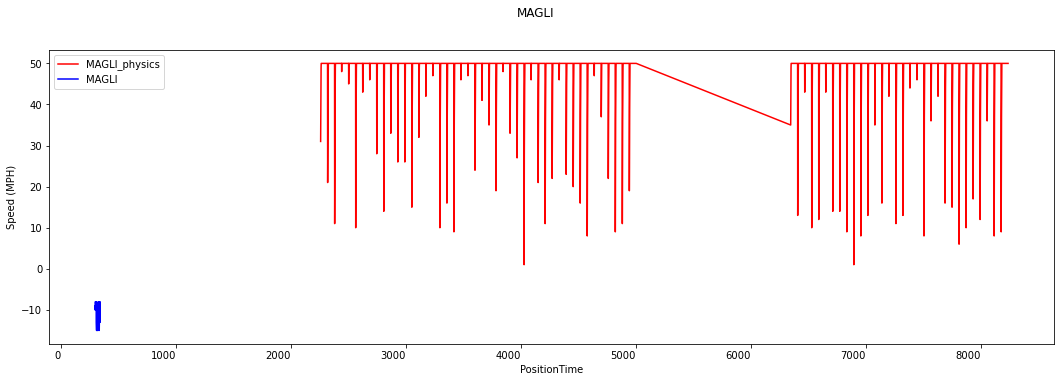

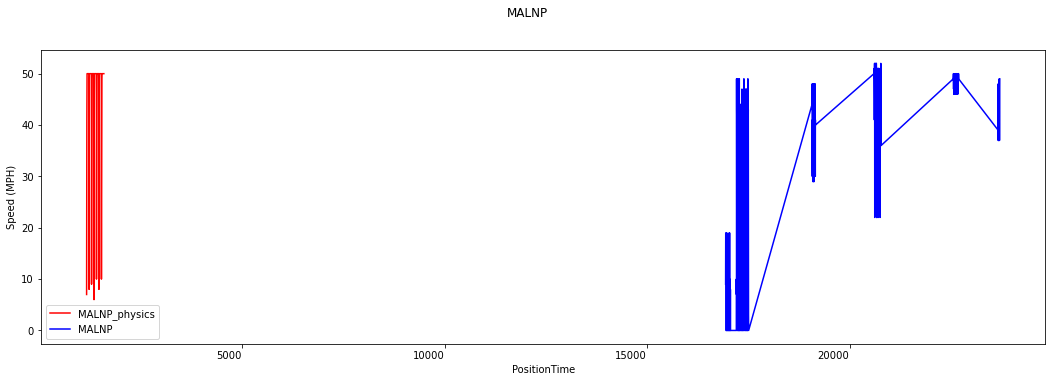

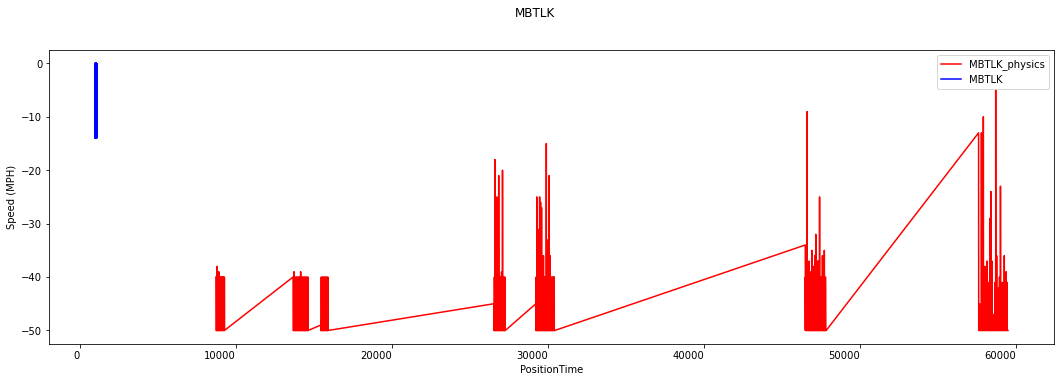

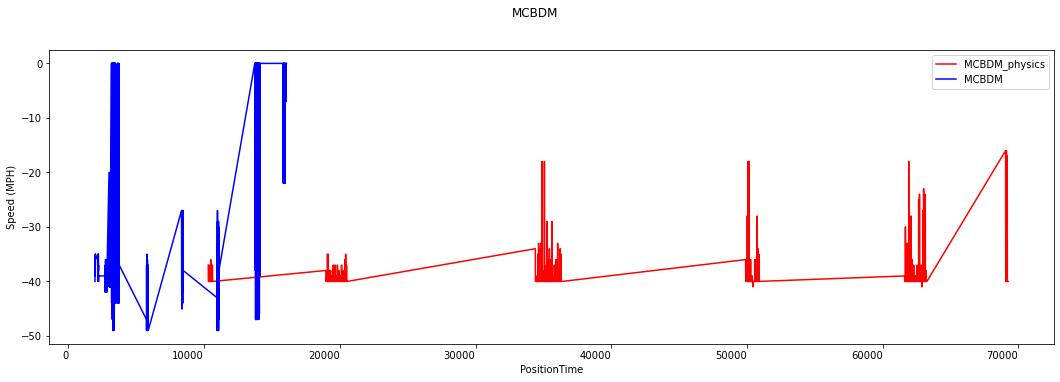

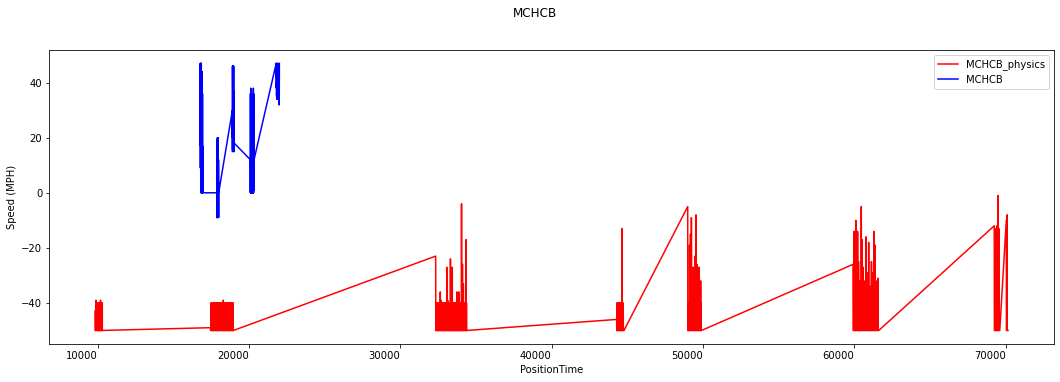

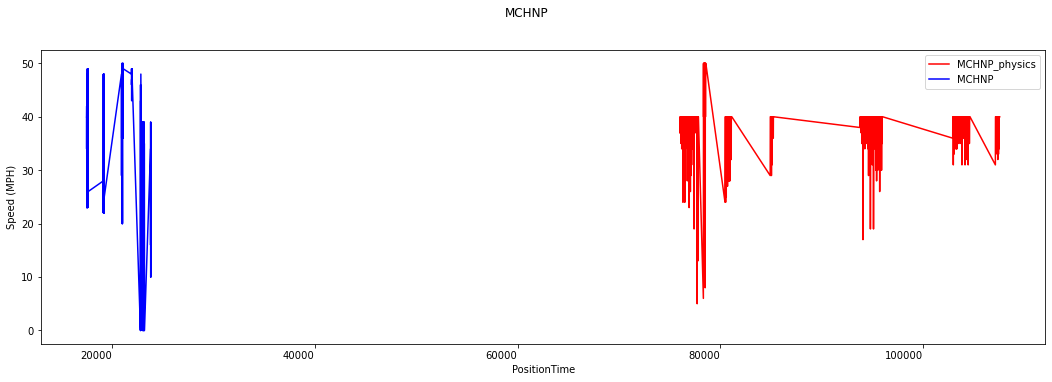

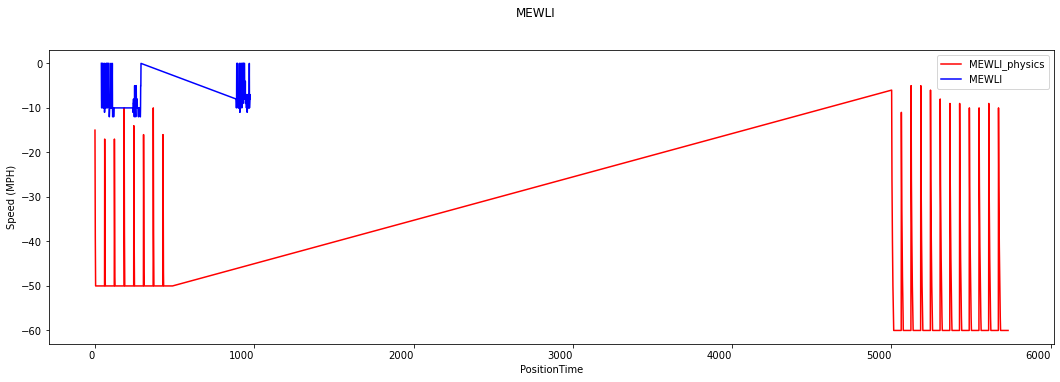

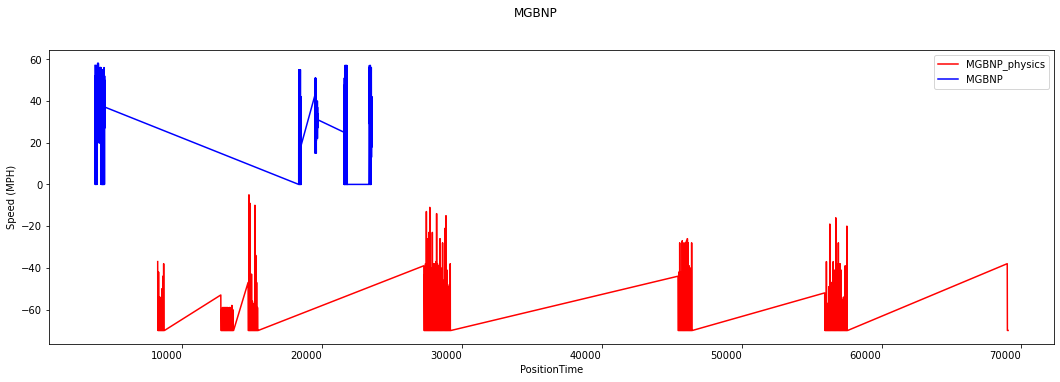

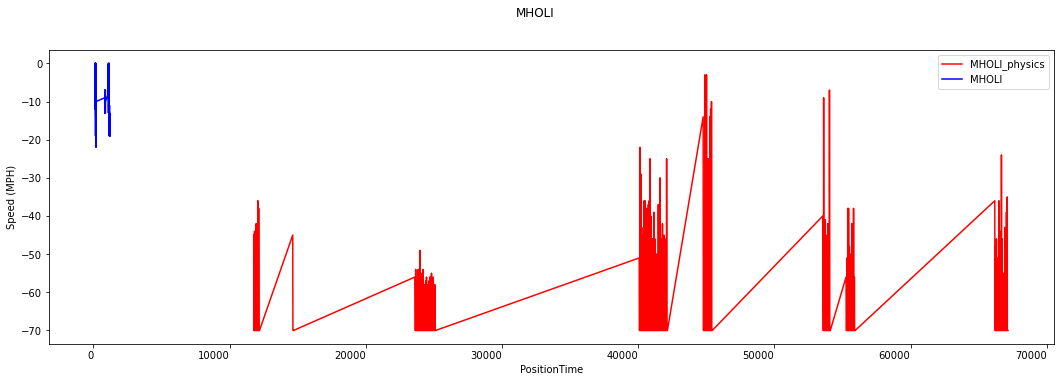

In [284]:
# Stack Physis Model vs Actual Data.
# Evolution of Features over time
plot_cols = ['TrainSymbol', 'SpeedMPH', 'MilepostNumber']
plot_features = aggregateDataFrame[plot_cols]
physics_plot_features = trainEstimatedPositionDataFrame[plot_cols]

# Inverse TrainSymbol - for some reason have to do this everytime.
plot_features.loc[:,'TrainSymbol'] = train_symbol_encoder.inverse_transform(plot_features.loc[:,'TrainSymbol'])
physics_plot_features.loc[:,'TrainSymbol'] = train_symbol_encoder.inverse_transform(physics_plot_features.loc[:,'TrainSymbol'])

groupby_df = plot_features[plot_cols].groupby('TrainSymbol')
physics_groupby_df = physics_plot_features[plot_cols].groupby('TrainSymbol')

# Iterate through subplots to add train symbol title
for key in physics_groupby_df.groups.keys():
    ax = physics_groupby_df.get_group(key).plot(subplots=True, kind='line', y='SpeedMPH', title=key, xlabel='PositionTime', ylabel='Speed (MPH)', label=str(key) + '_physics', color='red', figsize=(18,6))
    groupby_df.get_group(key).plot(ax=ax, subplots=True, kind='line', y='SpeedMPH', title=key, label=key, color='blue', figsize=(18,6))

In [208]:
# Inspect and clean up - look at statistics of dataset
aggregateDataFrame.describe().transpose()

count         mean          std     min        25%  \
EmptyCarCount    23885.0    52.307097    48.580311     0.0     0.0000   
LoadedCarCount   23885.0    77.604982    63.350222     0.0    30.0000   
MilepostNumber   23885.0   288.447850   128.745814     0.0   227.3577   
SpeedMPH         23885.0    -5.257023    35.187070   -65.0   -39.0000   
SubdivisionId    23885.0   108.785472    39.430311     0.0   106.0000   
TrackName        23885.0     4.657526     2.038613     0.0     4.0000   
TrailingTonnage  23885.0  8787.863931  5907.063802  2424.0  5079.0000   
TrainLength      23885.0  8718.135650  2983.659925  2847.0  6197.0000   
TrainSymbol      23885.0    15.580699     9.119032     0.0     7.0000   

                       50%         75%         max  
EmptyCarCount      56.0000     97.0000    167.0000  
LoadedCarCount     69.0000    101.0000    258.0000  
MilepostNumber    260.6377    299.3312    766.9316  
SpeedMPH            0.0000     28.0000     62.0000  
SubdivisionId     106.0000    106.0000    595.0000  
TrackName           4.0000      5.0000     18.0000  
TrailingTonnage  7387.0000  11039.0000  36894.0000  
TrainLength      8605.0000  10156.0000  15237.0000  
TrainSymbol        15.0000     25.0000     31.0000

Text(0.5, 1.0, 'Time of day signal thing')

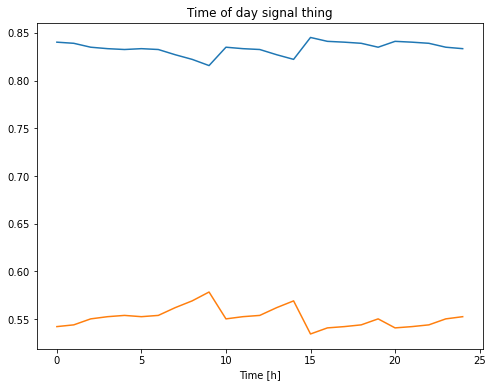

In [209]:
# Date time updates
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

dateTimeDataframe = pd.DataFrame()

dateTimeDataframe['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
dateTimeDataframe['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
dateTimeDataframe['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
dateTimeDataframe['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(dateTimeDataframe['Day sin'])[:25])
plt.plot(np.array(dateTimeDataframe['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal thing')

In [210]:
# Randomize the data set
if randomizeDataFrame is True:
    # frac=1 means all rows of a data frame
    # random_state=42 means keeping the same order in each execution
    # reset_index(drop=True) means reinitialize index for randomized dataframe
    aggregateDataFrame = aggregateDataFrame.sample(frac=1, random_state=42).reset_index(drop=True)
    print("Randomizing DataFrame frac=1, random_state=2, reset_index:drop=true")
    aggregateDataFrame.head()

In [211]:
# Finally get to some training things - split the data

column_indices = {name: i for i, name in enumerate(aggregateDataFrame.columns)}

print('Column Indices', column_indices)

n = len(aggregateDataFrame)

# Splitting the data set
test_percentage = trainDataPercentage + valDataPercentage
train_df = aggregateDataFrame[0:int(n*trainDataPercentage)]
val_df = aggregateDataFrame[int(n*trainDataPercentage):int(n*test_percentage)]
test_df = aggregateDataFrame[int(n*test_percentage):]

print('Train Percent:', str(trainDataPercentage))
print('Val Percent:', str(valDataPercentage))
print('Test Percent:', str(round(1 - test_percentage, 1)))

num_features = aggregateDataFrame.shape[1]

Column Indices {'EmptyCarCount': 0, 'LoadedCarCount': 1, 'MilepostNumber': 2, 'SpeedMPH': 3, 'SubdivisionId': 4, 'TrackName': 5, 'TrailingTonnage': 6, 'TrainLength': 7, 'TrainSymbol': 8}
Train Percent: 0.7
Val Percent: 0.2
Test Percent: 0.1


In [212]:
# Now we normalize the data - required before training a neural network. 

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

print('Train df:', str(train_df))
print('Val df:', str(val_df))
print('Test df:', str(test_df))

Train df:        EmptyCarCount  LoadedCarCount  MilepostNumber  SpeedMPH  SubdivisionId  \
0           1.091167       -0.443927        3.122311  0.261153      -0.102563   
1           1.091167       -0.443927        3.123200  0.223281      -0.102563   
2           1.091167       -0.443927        3.126562  0.185409      -0.102563   
3           1.091167       -0.443927        3.127794  0.185409      -0.102563   
4           1.091167       -0.443927        3.128490  0.223281      -0.102563   
...              ...             ...             ...       ...            ...   
16714      -1.073223        0.676915       -0.464484  2.836468      -0.102563   
16715      -1.073223        0.676915       -0.603756  2.230511      -0.102563   
16716      -1.073223        0.676915       -0.615037  2.874340      -0.102563   
16717      -1.073223        0.676915       -0.635997  2.912212      -0.102563   
16718      -1.073223        0.676915       -0.645838  2.722851      -0.102563   

       TrackName 

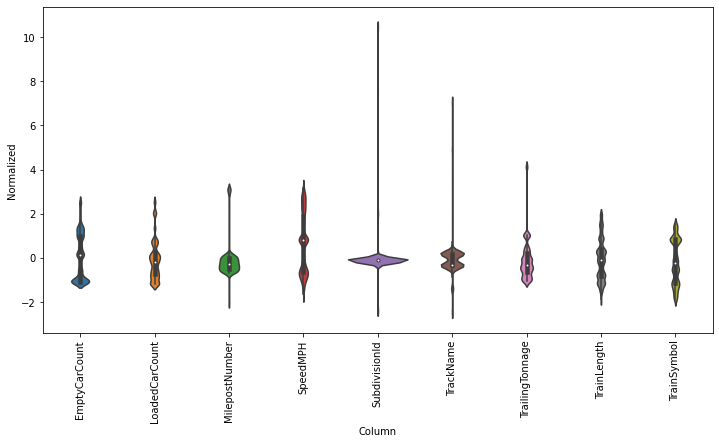

In [213]:
# View distribution of the features - look for obvious errors here
df_std = (aggregateDataFrame - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))

ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(aggregateDataFrame.keys(), rotation=90)

In [214]:
# Data Windowing - done for reuse and for making prediction x hours into the future given y hours of history
# Main features: width of input and label windows, time offset between them, which features are used as inputs, labels or both

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [215]:
# Now add code to create 2 windows  (note: try different columns here)

w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['MilepostNumber'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['MilepostNumber']

In [216]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['MilepostNumber'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['MilepostNumber']

In [301]:
# Pull out the layer's weights and visualize the weight assigned to each input
def weight_graph(model):
    plt.bar(x = range(len(train_df.columns)),
            height=model.layers[0].kernel[:,0].numpy())
    axis = plt.gca()
    axis.set_xticks(range(len(train_df.columns)))
    _ = axis.set_xticklabels(train_df.columns, rotation=90)

In [325]:
# Pull out the layer's weights and visualize the weight assigned to each input
def bias_graph(model, layer_name):
    biases = model.get_layer(layer_name).get_weights()[1]
    plt.bar(x = range(len(train_df.columns)),
            height=biases)
    axis = plt.gca()
    axis.set_xticks(range(len(train_df.columns)))
    _ = axis.set_xticklabels(train_df.columns, rotation=90)

In [218]:
# Utility function 
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [219]:
# Make use of the window splitting feature
# Note you need enough data for this to work

# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 9)
Inputs shape: (3, 6, 9)
Labels shape: (3, 1, 1)


In [341]:
# Now, plot!
# w2.example = example_inputs, example_labels

def plot(self, model=None, plot_col='MilepostNumber', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [367]:
# function to compare single sample input plots
def plot_comparison(self, models=[], plot_col='MilepostNumber'):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  
  plt.subplot(len(models), 1, 1)
  plt.ylabel(f'{plot_col} [normed]')
  plt.plot(self.input_indices, inputs[0, :, 0],
            label='Inputs', marker='.', zorder=-10)

  plt.scatter(self.label_indices, labels[0, :, 0],
              edgecolors='k', label='Labels', c='#2ca02c', s=64)
  plt.legend()
  plt.xlabel('Time [h]')

  # Iterable count for labeling
  n = 0

  for model in models:
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[0, :, 0],
                  marker='X', edgecolors='k', label= n,
                  c='#ff7f0e', s=64)

    n = n + 1

WindowGenerator.plot_comparison = plot_comparison

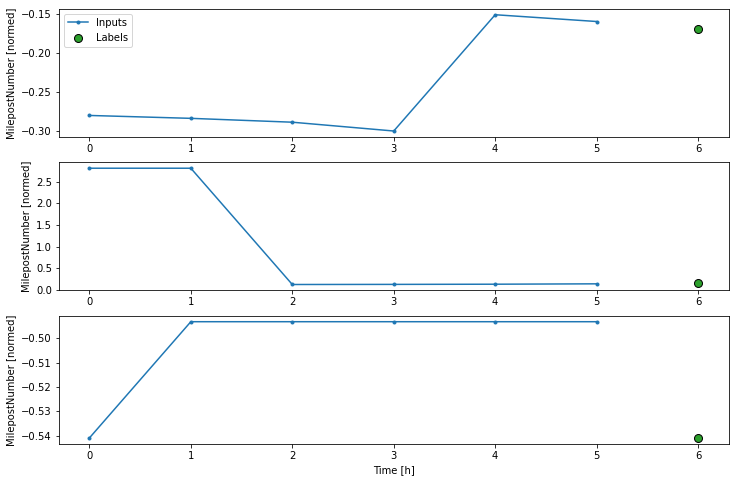

In [345]:
# Here is where we show the plot
w2.plot()

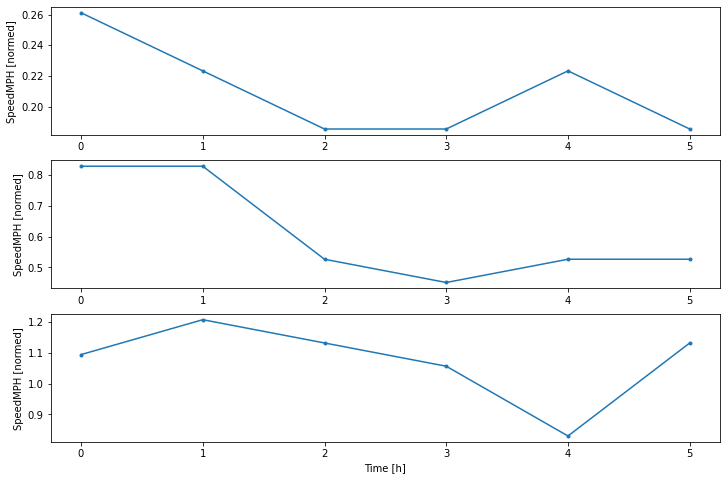

In [222]:
w2.plot(plot_col='SpeedMPH')

In [223]:
# Make some datasets
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [224]:
# Add properties to the datasets
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [225]:
# The window generator gives us access to the tensor flow dataset objects for easy iteration 
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [226]:
# let's look at concrete batches
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 9)
Labels shape (batch, time, features): (32, 1, 1)


In [227]:
# Need to configure a window generator to produce single-step pairs
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['MilepostNumber'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['MilepostNumber']

In [228]:
# Once again, look at the batches of date:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 9)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

In [229]:
# Build a performance baseline - to use as point for comparison
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [230]:
# Instantiate and evaluate the model:
baseline = Baseline(label_index=column_indices['MilepostNumber'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

150/150 [==============================] - 0s 1ms/step - loss: 0.0367 - mean_absolute_error: 0.0406


In [231]:
# Still, we don't know how well the model is doing. Generate more info
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['MilepostNumber'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['MilepostNumber']

In [232]:
# Now print the shapes
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


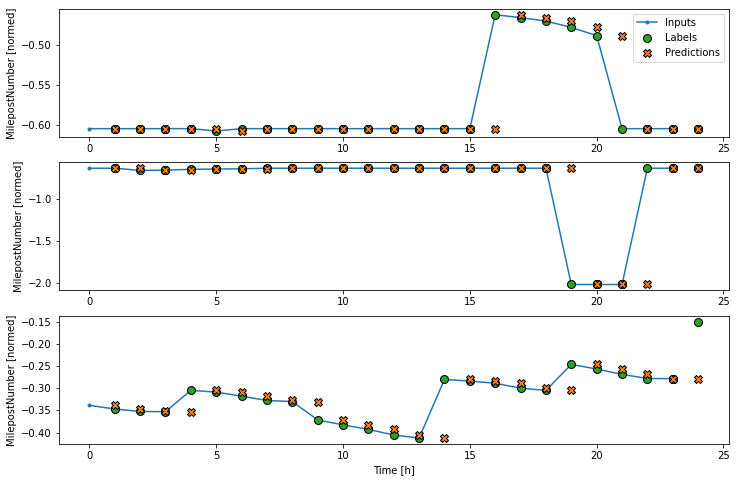

In [233]:
wide_window.plot(baseline, plot_col='MilepostNumber')

In [234]:
# Now, let's start looking at a Linear Model! Note that a Dense layer with no activation set is a linear model
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 9)
Output shape: (32, 1, 1)


In [235]:
# Package training procedure into a function:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [236]:
# Train the model and evaluate its performance
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
523/523 [==============================] - 1s 1ms/step - loss: 0.6445 - mean_absolute_error: 0.3987 - val_loss: 0.0951 - val_mean_absolute_error: 0.2222
Epoch 2/20
523/523 [==============================] - 1s 1ms/step - loss: 0.2239 - mean_absolute_error: 0.1439 - val_loss: 0.0368 - val_mean_absolute_error: 0.0916
Epoch 3/20
523/523 [==============================] - 1s 1ms/step - loss: 0.1287 - mean_absolute_error: 0.0856 - val_loss: 0.0362 - val_mean_absolute_error: 0.0747
Epoch 4/20
523/523 [==============================] - 1s 1ms/step - loss: 0.0987 - mean_absolute_error: 0.0751 - val_loss: 0.0385 - val_mean_absolute_error: 0.0783
Epoch 5/20
150/150 [==============================] - 0s 832us/step - loss: 0.0396 - mean_absolute_error: 0.0783


In [237]:
# Again, print the shapes
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


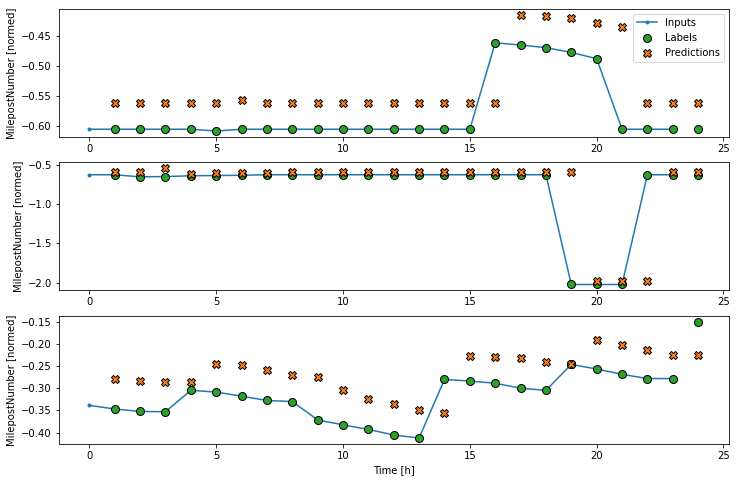

In [238]:
wide_window.plot(linear)

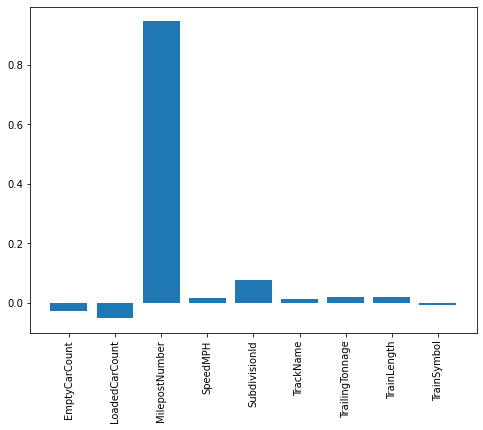

In [304]:
weight_graph(linear)

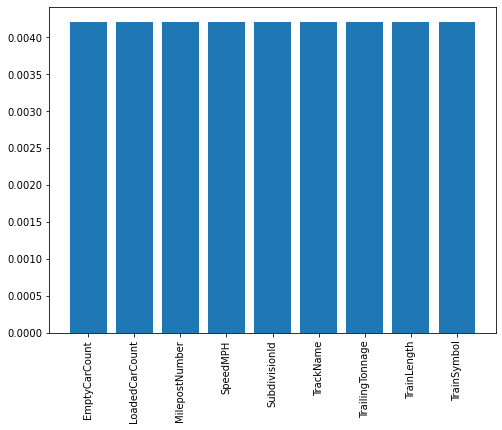

In [326]:
# Does this only have the one bias?
bias_graph(linear, 'dense_30')

### Dense Model

In [240]:
# Now it's time to look at a Dense model. Note the stacking of layers between input and output
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
523/523 [==============================] - 1s 2ms/step - loss: 0.1351 - mean_absolute_error: 0.1368 - val_loss: 0.0679 - val_mean_absolute_error: 0.1656
Epoch 2/20
523/523 [==============================] - 1s 1ms/step - loss: 0.0849 - mean_absolute_error: 0.0907 - val_loss: 0.0456 - val_mean_absolute_error: 0.1078
Epoch 3/20
523/523 [==============================] - 1s 1ms/step - loss: 0.0844 - mean_absolute_error: 0.0850 - val_loss: 0.0616 - val_mean_absolute_error: 0.1230
Epoch 4/20
150/150 [==============================] - 0s 862us/step - loss: 0.0715 - mean_absolute_error: 0.1605


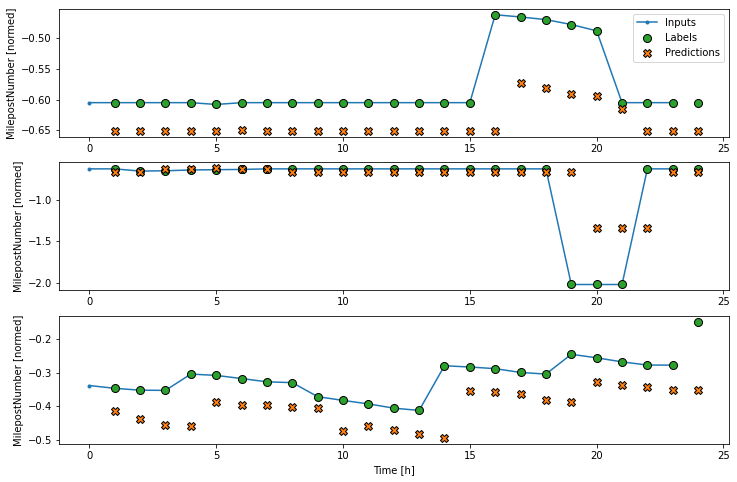

In [241]:
wide_window.plot(dense)

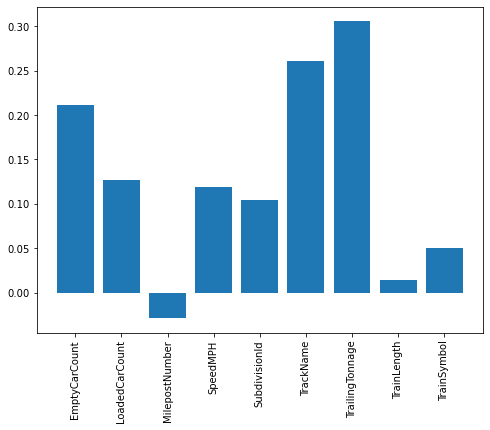

In [242]:
weight_graph(dense)

### Multi Dense Model

In [243]:
# Create another window generator to produce batches of inputs and labels
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['MilepostNumber'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['MilepostNumber']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

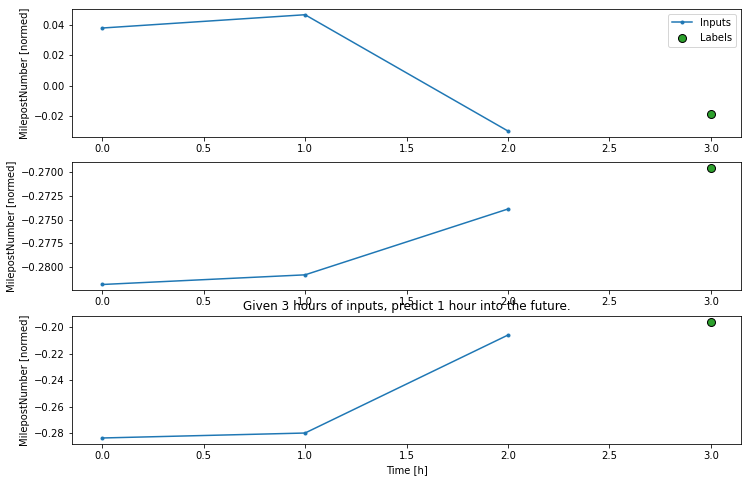

In [244]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

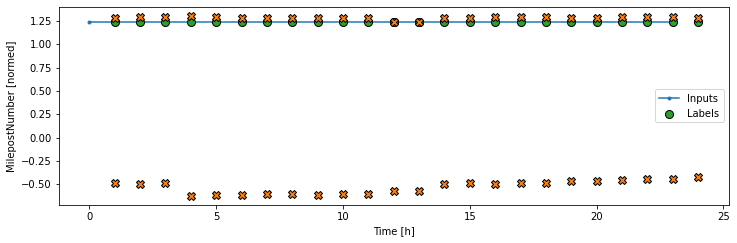

In [368]:
wide_window.plot_comparison(models=[linear, dense])

In [245]:
# Try adding a flatten layer as the first layer. Why? To possibly train on a multi-input-step 
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [246]:
# Shape time
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 9)
Output shape: (32, 1, 1)


In [247]:
# Compile and fit the model. Then evaluate
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

150/150 [==============================] - 0s 832us/step - loss: 0.0621 - mean_absolute_error: 0.1460


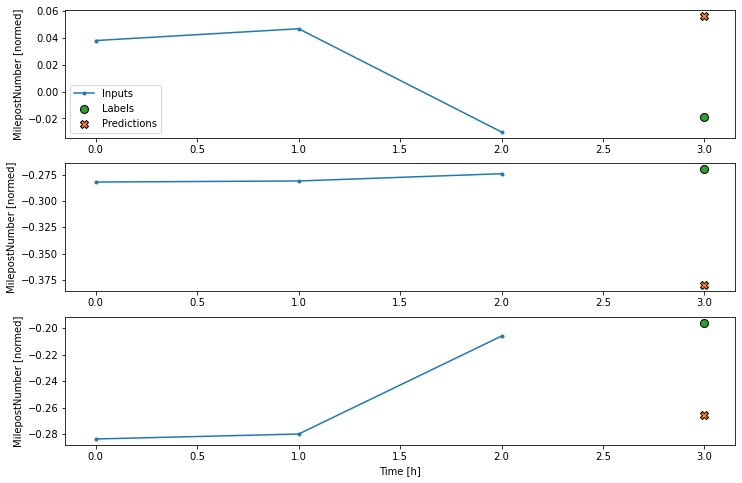

In [248]:
conv_window.plot(multi_step_dense)

### Convolution Neural Network

In [249]:
# Convolution Nural Network time! These also take multiple time steps as input to each prediction
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [250]:
# Run on an example batch - does the model produce the expected shape? 
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 9)
Output shape: (32, 1, 1)


In [251]:
# Train and evaluate the model on the conv_window and it should give similar performance to the multi step dense model:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

150/150 [==============================] - 0s 866us/step - loss: 0.0745 - mean_absolute_error: 0.1451


In [252]:
# Run it on wider input, produce wider output?
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 9)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [253]:
# We need the labels and prediction to have the same length. So, let's build a WindowGenerator, shall we? 

LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['MilepostNumber'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['MilepostNumber']

In [254]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 9)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


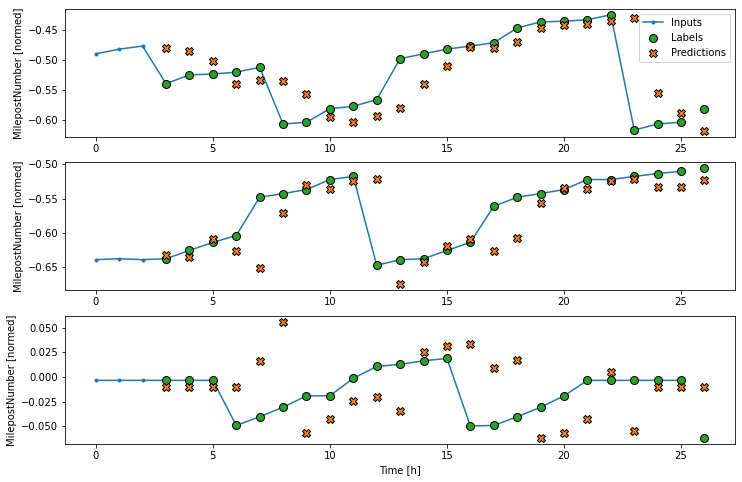

In [255]:
wide_conv_window.plot(conv_model)

### Recurrent Neural Network

A Recurrent Neural Network is a type of neural network well-suited to time series data. RNNs process a time series step by step.
We'll use Long short-term memory (LSTM) here

In [256]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [257]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


In [258]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

149/149 [==============================] - 0s 2ms/step - loss: 0.0770 - mean_absolute_error: 0.1408


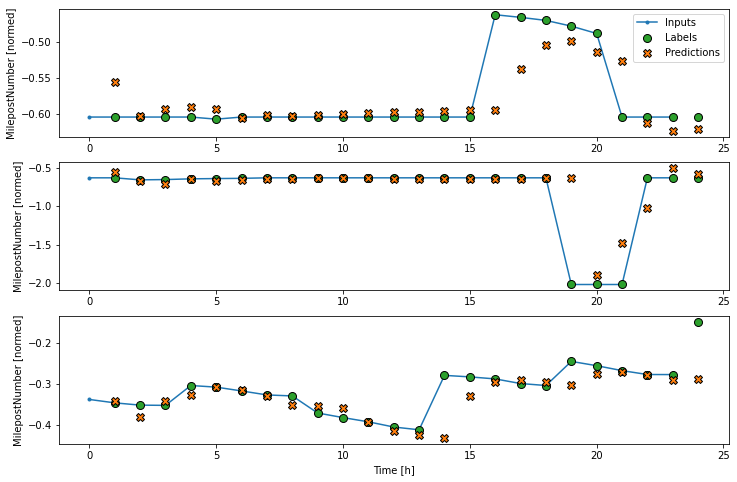

In [259]:
wide_window.plot(lstm_model)

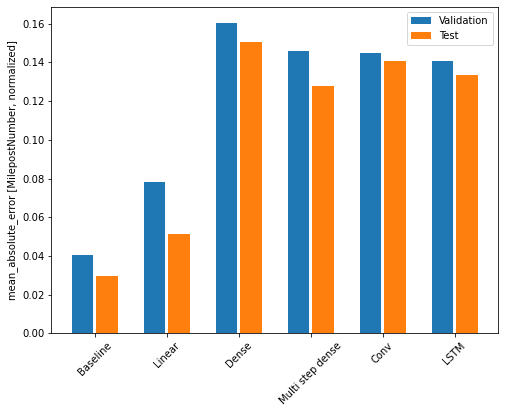

In [260]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [MilepostNumber, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [261]:
# Print the values for text comparison
for name, value in performance.items():
  print(f'{name:18s}: {value[1]:0.4f}')

Baseline          : 0.0298
Linear            : 0.0511
Dense             : 0.1504
Multi step dense  : 0.1278
Conv              : 0.1409
LSTM              : 0.1333


### Multi-output Models
Convert all prior single step models to multi-output models by changing the number of units in the output layer and adjusting the training windows to include all features

In [262]:
# What do multi-output models look like? Can we predict multiple features? Yes, just change the number of units in the output layer,
# and adjust the training windows to inlude all features in the labels 

single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 9)
Labels shape (batch, time, features): (32, 24, 9)


In [263]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [264]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

149/149 [==============================] - 0s 831us/step - loss: 0.1620 - mean_absolute_error: 0.0575


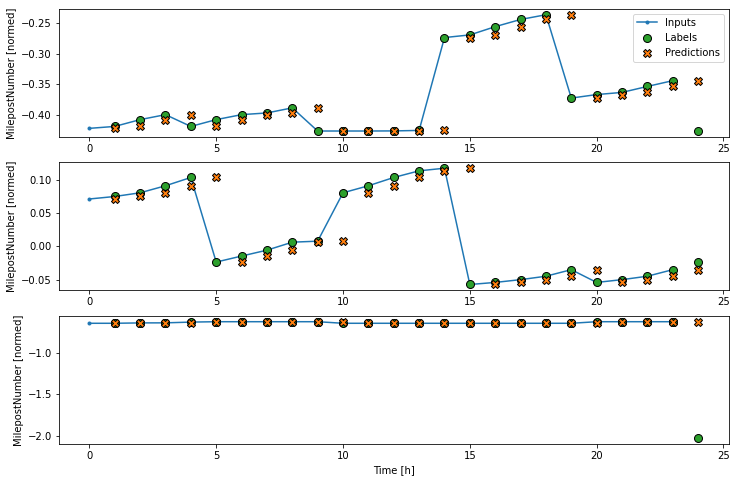

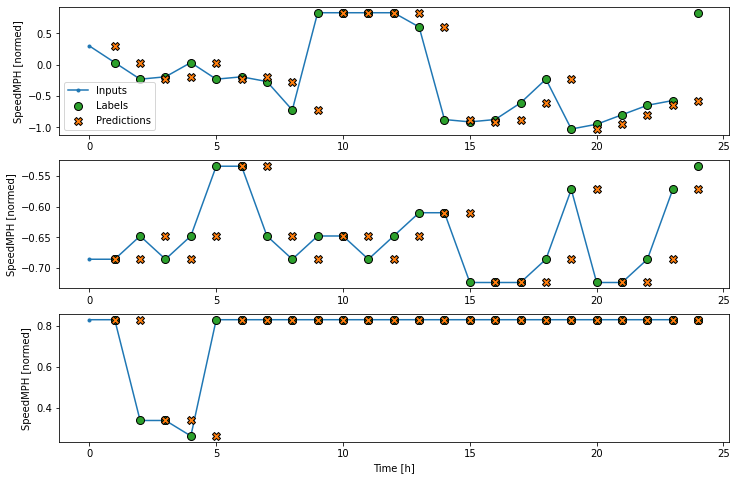

In [265]:
wide_window.plot(baseline)
wide_window.plot(baseline, plot_col='SpeedMPH')

#### Dense Model

In [266]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [267]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

150/150 [==============================] - 0s 879us/step - loss: 0.1901 - mean_absolute_error: 0.1742


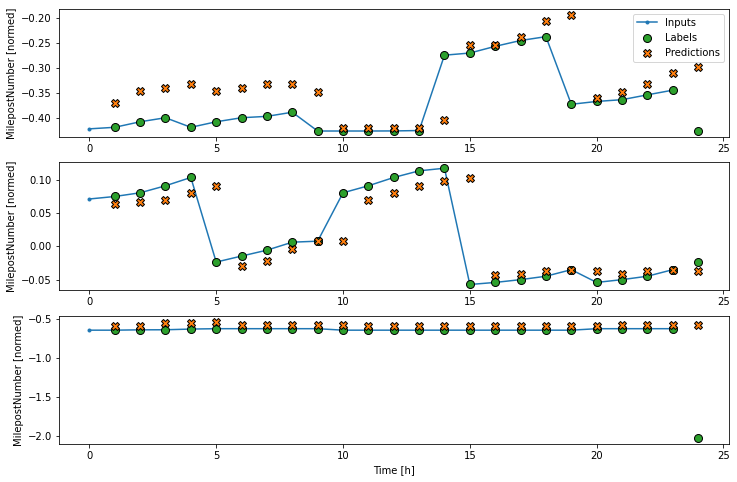

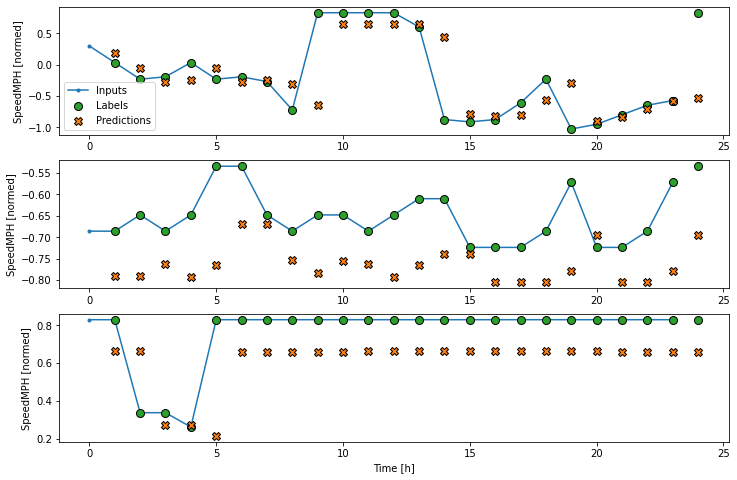

In [268]:
wide_window.plot(dense)
wide_window.plot(dense, plot_col='SpeedMPH')

#### Recurrent Neural Network

In [269]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)


149/149 [==============================] - 0s 2ms/step - loss: 0.1771 - mean_absolute_error: 0.1532


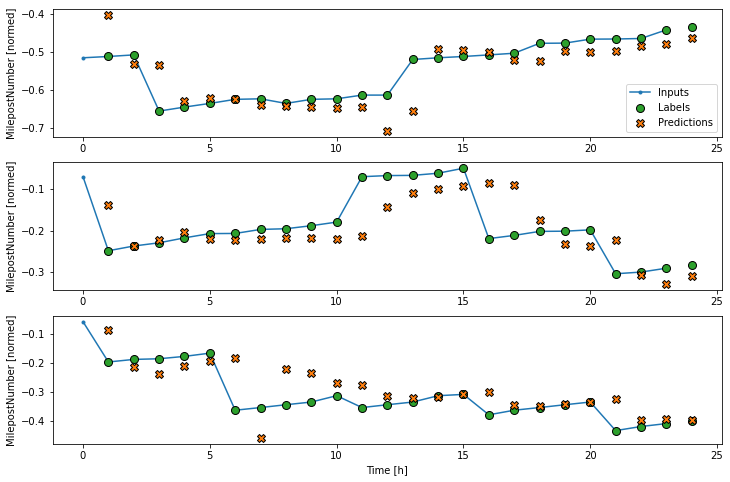

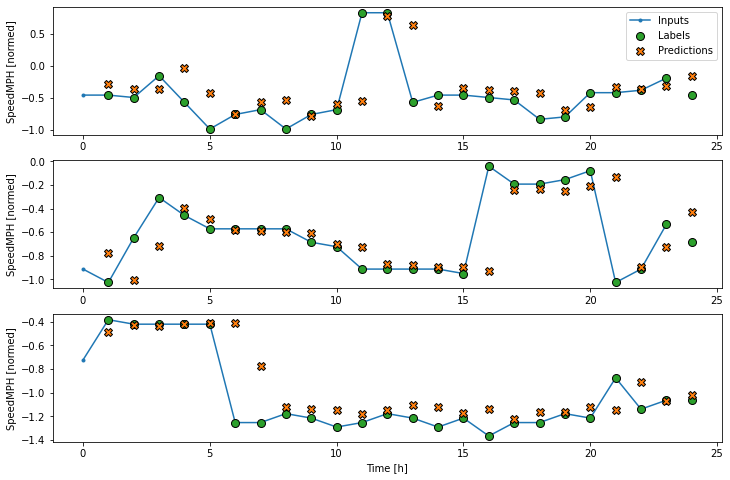

In [270]:
wide_window.plot(lstm_model)
wide_window.plot(lstm_model, plot_col='SpeedMPH')

#### Residual Connections
Instead of trying to predict the next value - attempt to predict how the value will change. 

In [271]:
# Look at a Residual Network - each layer adds to the model's accumulating result
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [272]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)

149/149 [==============================] - 0s 2ms/step - loss: 0.1655 - mean_absolute_error: 0.1017


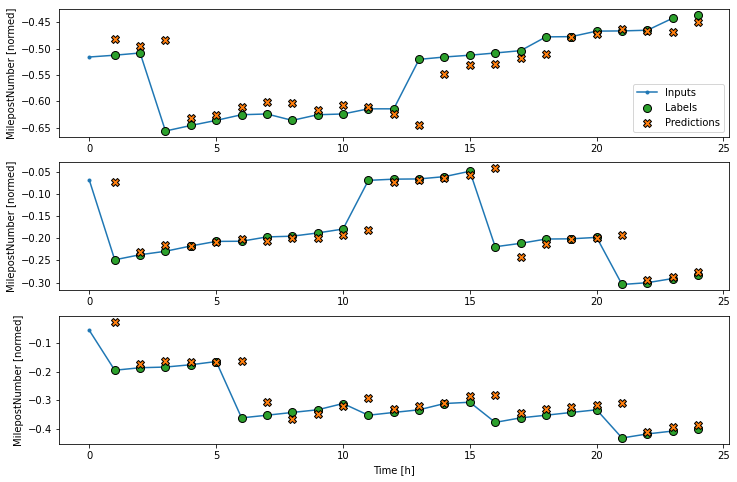

In [363]:
wide_window.plot(residual_lstm)

### Performance - Multi-output models

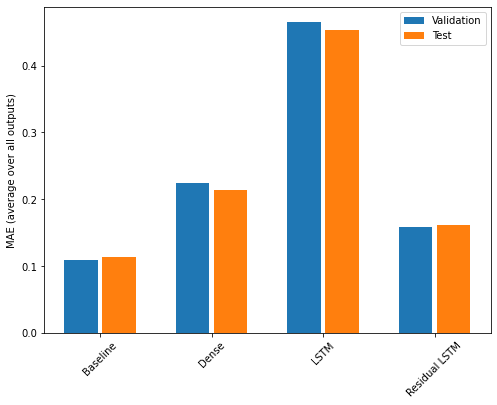

In [ ]:
# Once again, let's look at model performance comparison, now with more layers! (new and improved ;))
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1134
Dense          : 0.2132
LSTM           : 0.4529
Residual LSTM  : 0.1610


## Multi-step Models

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

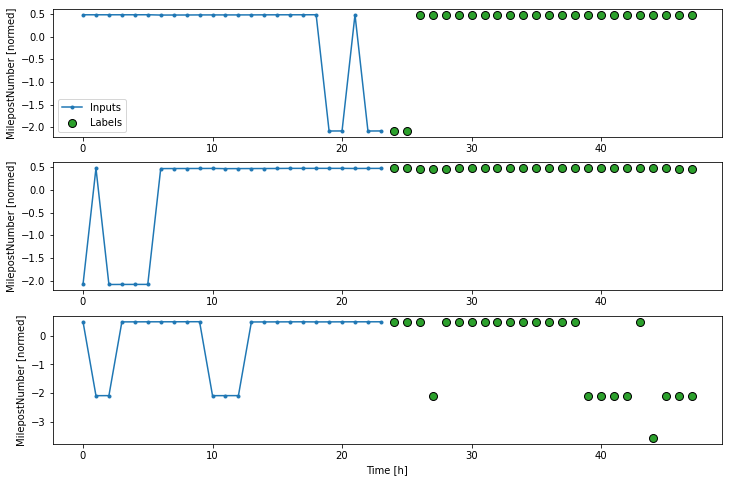

In [ ]:
# Begin looking at multi step models. The idea is to do multiple time step predictions. The model needs to learn to predict 
# a range of future values, like a sequence.  Think of predicting 24 hours into the future, given 24 hours of the past

OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

2/2 [==============================] - 0s 2ms/step - loss: 1.4362 - mean_absolute_error: 0.3533


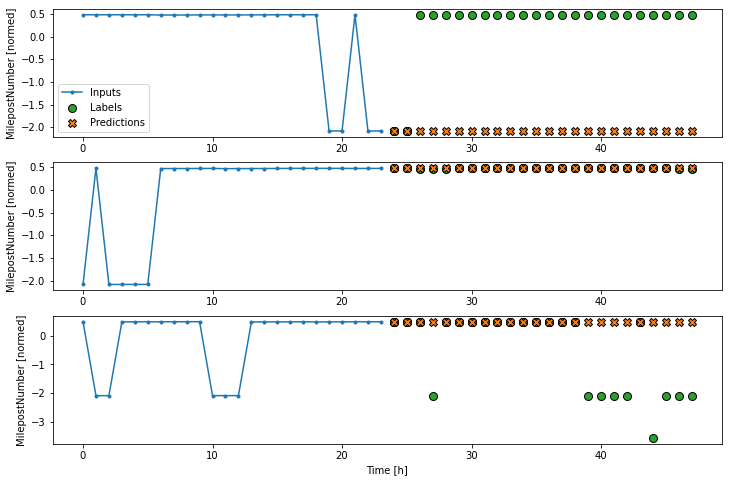

In [ ]:
# Create a function to repeat the last input time step for some number of output time steps
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

2/2 [==============================] - 0s 2ms/step - loss: 1.5417 - mean_absolute_error: 0.3731


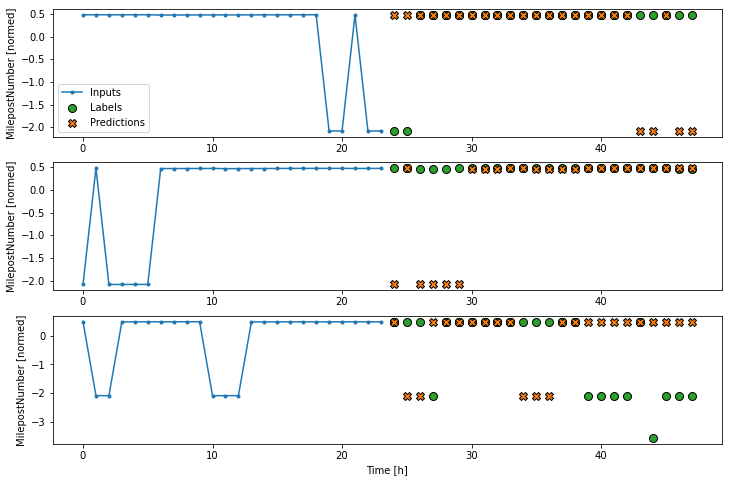

In [ ]:
# Now create a function to repeat the baseline
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single Shot Models
#### Linear Model

2/2 [==============================] - 0s 1ms/step - loss: 2.0065 - mean_absolute_error: 0.7844


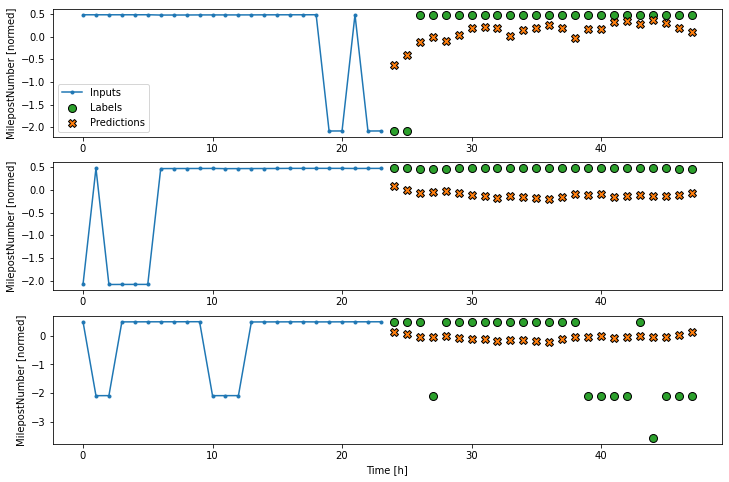

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense Model

2/2 [==============================] - 0s 1ms/step - loss: 1.8062 - mean_absolute_error: 0.6644


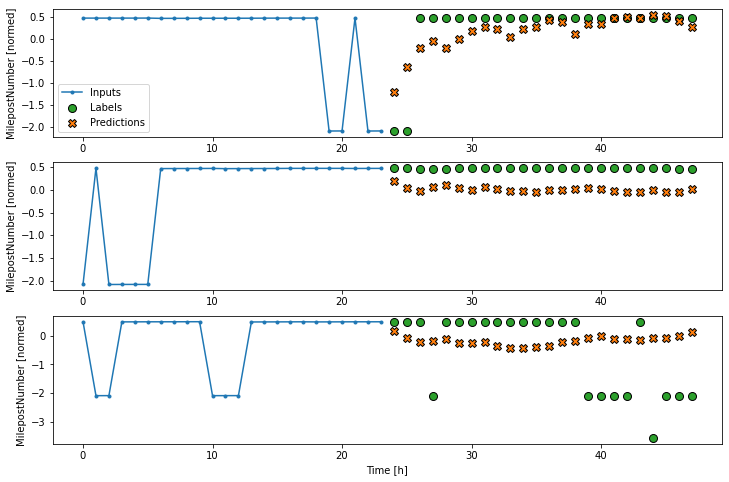

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### Convolutional Model

2/2 [==============================] - 0s 2ms/step - loss: 1.7829 - mean_absolute_error: 0.6921


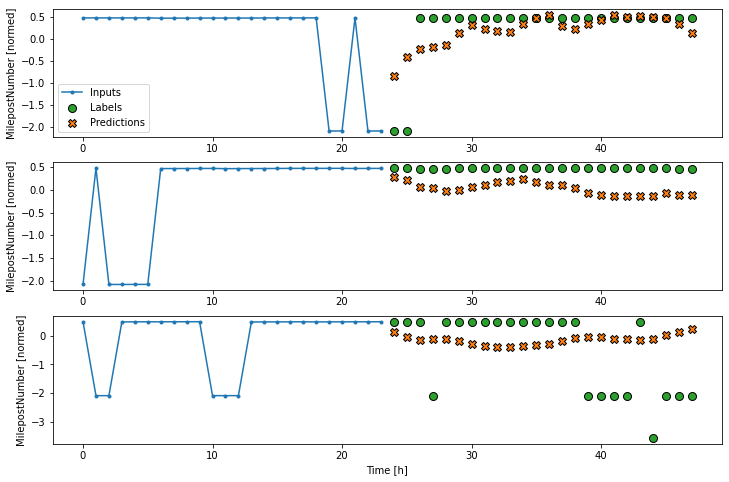

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### Reccurrent Model

2/2 [==============================] - 0s 3ms/step - loss: 1.8035 - mean_absolute_error: 0.7120


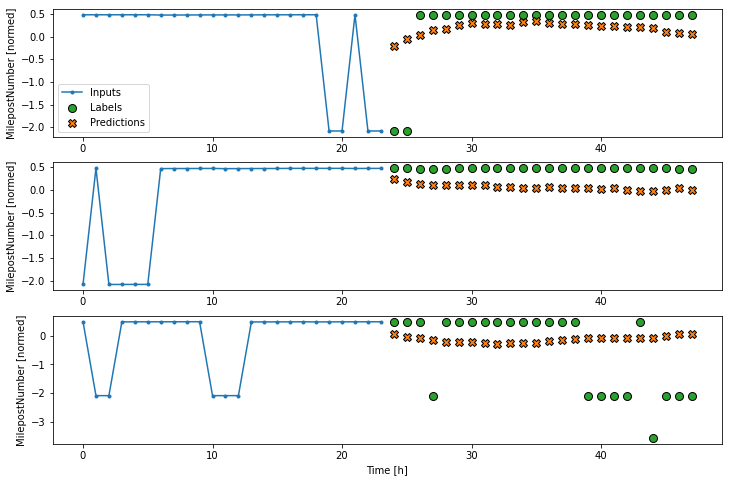

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Autoregressive Models
The above models all predict the entire output sequence in a single step.

#### Recurrent Neural Network

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)


In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 9])

In [ ]:
# Do the actual prediction - having to collect output predictions and retain them while iterating through each step

def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
# Run on example inputs and see the shape:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 9)


2/2 [==============================] - 0s 5ms/step - loss: 1.8544 - mean_absolute_error: 0.8053


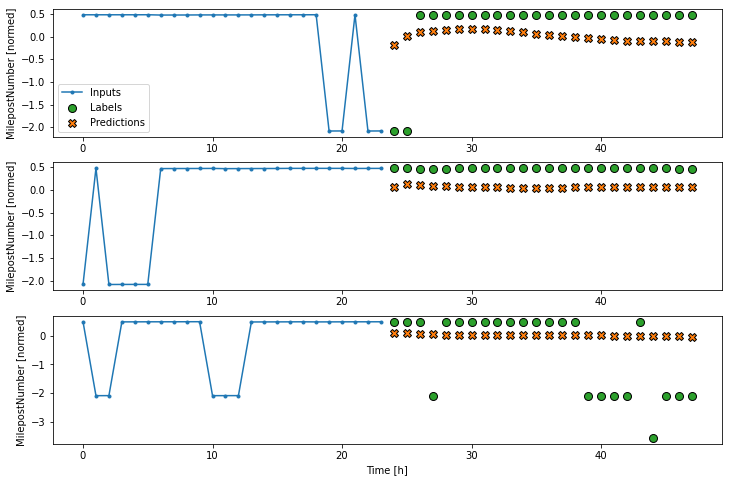

In [ ]:
# Now train the model
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

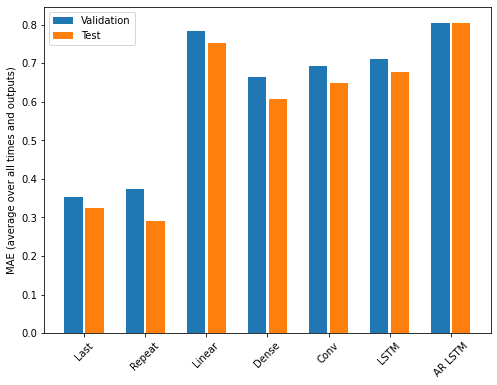

In [ ]:
# Evaluate Performance
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [ ]:
# Text output for easy comparison 
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.3252
Repeat  : 0.2918
Linear  : 0.7512
Dense   : 0.6081
Conv    : 0.6483
LSTM    : 0.6764
AR LSTM : 0.8048
